### <span style="color:#d35400">Problem Statement:</span>

   In the dynamic and competitive world of the hotel industry, understanding the factors that influence booking cancellations is crucial. Cancellations can lead to lost revenue and inefficiencies in hotel operations. This dataset, containing booking information for a city hotel and a resort hotel, provides an opportunity to explore this issue in depth. The data includes variables such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among others. All personally identifying information has been removed from the data.

   The objective is to analyze and identify the key factors that influence hotel booking cancellations. Are there specific times of the year when cancellations are more prevalent? Do certain guest demographics tend to cancel more than others? How does the length of stay or lead time affect the likelihood of cancellation? By exploring these questions and more, we aim to provide valuable insights that can help hotels mitigate cancellations and enhance their revenue management strategies.

### <span style="color:#d35400">Business Objective:</span>

   The main aim is to perform Exploratory Data Analysis (EDA) on the dataset to uncover insights into the factors influencing hotel booking cancellations. Through this analysis, we aim to identify patterns, correlations, and trends that shed light on why cancellations occur, helping us understand the interplay of different variables in the hotel booking process.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import time
import calendar
import warnings

import missingno as msno
import sidetable as stb
import ppscore as pps

from sklearn.inspection import permutation_importance
from sklearn.experimental import enable_halving_search_cv
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeCV, Ridge
from sklearn.metrics import (precision_recall_fscore_support, balanced_accuracy_score, roc_auc_score, 
                             ConfusionMatrixDisplay, RocCurveDisplay)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from collections import Counter

### <span style="color:#d35400">Load the data</span>

In [2]:
# Load the dataset
df = pd.read_csv('data/hotel_booking.csv')

In [3]:
# Print the first 5 rows.
df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  customer_type  \
0                        0                     0       2  ...      Transient   
1                        0                     0       2  ...      Transient   
2                        0                     1       1  ...      Transient   
3                        0                     1       1  ...      Transient   
4                        0                     2       2  ...      Transient   

    adr required_car_parking_spaces total_of_special_requests  \
0   0.0                           0                         0   
1   0.0                           0                         0   
2  75.0                           0                         0   
3  75.0                           0                         0   
4  98.0                           0                         1   

  reservation_status reservation_status_date            name  \
0          Check-Out              2015-07-01   Ernest Barnes   
1          Check-Out              2015-07-01    Andrea Baker   
2          Check-Out              2015-07-02  Rebecca Parker   
3          Check-Out              2015-07-02    Laura Murray   
4          Check-Out              2015-07-03     Linda Hines   

                         email  phone-number       credit_card  
0  Ernest.Barnes31@outlook.com  669-792-1661  ************4322  
1       Andrea_Baker94@aol.com  858-637-6955  ************9157  
2   Rebecca_Parker@comcast.net  652-885-2745  ************3734  
3            Laura_M@gmail.com  364-656-8427  ************5677  
4           LHines@verizon.com  713-226-5883  ************5498  

[5 rows x 36 columns]

### <span style="color:#d35400">Understanding of the data</span>

In [4]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### <font color='purple'>Observations:</font>
   - 'is_canceled' column appears to be the target variable, indicating whether a booking was canceled (1) or not (0).
   - 'reservation_status' column might provide insights into the current status of bookings.

In [5]:
df.shape

(119390, 36)

### <font color='purple'>Observations:</font>
   - The dataset contains a total of 119,390 entries (rows) and 36 columns.

In [6]:
df.stb.freq(['is_canceled'], cum_cols = False)

is_canceled  count    percent
0            0  75166  62.958372
1            1  44224  37.041628

### <font color='purple'>Observations:</font>
   - The above cancellation rate is similar to the industry standard mentioned in the post https://revenue-hub.com/cancellations-rates-where-do-they-stand-and-how-to-overcome-them/   - 

In [7]:
# Retrieve Categorical and Numberical features from the dataset.
categorical_features = df.describe(include=["object"]).columns
numerical_features = df.describe().columns

In [8]:
# Print categorical features in the dataset.
categorical_features

Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type', 'reservation_status',
       'reservation_status_date', 'name', 'email', 'phone-number',
       'credit_card'],
      dtype='object')

In [9]:
# Print numerical features in the dataset.
numerical_features

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')

### <font color='purple'>Observations:</font>
   - The data consists of 20 numerical & 16 categorical features

In [10]:
# Print the unique values for the categorical columns
# Excluding columns that will not impact EDA and to avoid scrolling of the output because of too many values.
def print_categorical_unique_values(df, categorical_features, excluded_columns):
    for col in categorical_features:
        if col not in excluded_columns:
            print(f'\n\033[1m{col.strip()}\033[0m: ', df[col].unique())


excluded_columns = ['name', 'email', 'phone-number', 'credit_card', 'reservation_status_date']
print_categorical_unique_values(df, categorical_features, excluded_columns)


hotel:  ['Resort Hotel' 'City Hotel']

arrival_date_month:  ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']

meal:  ['BB' 'FB' 'HB' 'SC' 'Undefined']

country:  ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI'
 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB'
 'NPL' 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KN

### <font color='purple'>Observations:</font>
   - No Null values in the data
   - Some features need to handle missing or invalid values such as 'Undefined'
   - Some features have too many distinct values and require further analysis

### <span style="color:#d35400">Descriptive Statistics:</span>

In [11]:
# Summary statistics of categorical variables
df.describe(include=["object"])

hotel arrival_date_month    meal country market_segment  \
count       119390             119390  119390  118902         119390   
unique           2                 12       5     177              8   
top     City Hotel             August      BB     PRT      Online TA   
freq         79330              13877   92310   48590          56477   

       distribution_channel reserved_room_type assigned_room_type  \
count                119390             119390             119390   
unique                    5                 10                 12   
top                   TA/TO                  A                  A   
freq                  97870              85994              74053   

       deposit_type customer_type reservation_status reservation_status_date  \
count        119390        119390             119390                  119390   
unique            3             4                  3                     926   
top      No Deposit     Transient          Check-Out              2015-10-21   
freq         104641         89613              75166                    1461   

                   name                email  phone-number       credit_card  
count            119390               119390        119390            119390  
unique            81503               115889        119390              9000  
top     Michael Johnson  Michael.C@gmail.com  669-792-1661  ************4923  
freq                 48                    6             1                28

### <font color='purple'>Observations:</font>
   - The majority of bookings are for the city hotel (79,330), followed by the resort hotel (41,060). Which indicates dataset is biased towards city hotels.
   - 'August' has the highest frequency among arrival months, with 13,877 occurrences. Which indicates higher number of bookings during the summer months.
   - The majority of bookings seem to include breakfast (meal type - Bed & Breakfast) as part of the package.
   - The most frequent bookings from Portugal(PRT), with 48,590 bookings.
   - Online travel agents play a substantial role in the bookings (56,477).
   - Reserved Room type 'A' seems to be popular among the bookings (85,994).
   - A significant portion of bookings (104,641) does not require a deposit.
   - The dataset is primarily composed of transient customers (89,613).
   - The majority of reservations result in guests checking out (75,166).

In [12]:
# Summary statistics of quantitative variables
df.describe()

is_canceled      lead_time  arrival_date_year  \
count  119390.000000  119390.000000      119390.000000   
mean        0.370416     104.011416        2016.156554   
std         0.482918     106.863097           0.707476   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     160.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  arrival_date_day_of_month  \
count             119390.000000              119390.000000   
mean                  27.165173                  15.798241   
std                   13.605138                   8.780829   
min                    1.000000                   1.000000   
25%                   16.000000                   8.000000   
50%                   28.000000                  16.000000   
75%                   38.000000                  23.000000   
max                   53.000000                  31.000000   

       stays_in_weekend_nights  stays_in_week_nights         adults  \
count            119390.000000         119390.000000  119390.000000   
mean                  0.927599              2.500302       1.856403   
std                   0.998613              1.908286       0.579261   
min                   0.000000              0.000000       0.000000   
25%                   0.000000              1.000000       2.000000   
50%                   1.000000              2.000000       2.000000   
75%                   2.000000              3.000000       2.000000   
max                  19.000000             50.000000      55.000000   

            children         babies  is_repeated_guest  \
count  119386.000000  119390.000000      119390.000000   
mean        0.103890       0.007949           0.031912   
std         0.398561       0.097436           0.175767   
min         0.000000       0.000000           0.000000   
25%         0.000000       0.000000           0.000000   
50%         0.000000       0.000000           0.000000   
75%         0.000000       0.000000           0.000000   
max        10.000000      10.000000           1.000000   

       previous_cancellations  previous_bookings_not_canceled  \
count           119390.000000                   119390.000000   
mean                 0.087118                        0.137097   
std                  0.844336                        1.497437   
min                  0.000000                        0.000000   
25%                  0.000000                        0.000000   
50%                  0.000000                        0.000000   
75%                  0.000000                        0.000000   
max                 26.000000                       72.000000   

       booking_changes          agent      company  days_in_waiting_list  \
count    119390.000000  103050.000000  6797.000000         119390.000000   
mean          0.221124      86.693382   189.266735              2.321149   
std           0.652306     110.774548   131.655015             17.594721   
min           0.000000       1.000000     6.000000              0.000000   
25%           0.000000       9.000000    62.000000              0.000000   
50%           0.000000      14.000000   179.000000              0.000000   
75%           0.000000     229.000000   270.000000              0.000000   
max          21.000000     535.000000   543.000000            391.000000   

                 adr  required_car_parking_spaces  total_of_special_requests  
count  119390.000000                119390.000000              119390.000000  
mean      101.831122                     0.062518                   0.571363  
std        50.535790                     0.245291                   0.792798  
min        -6.380000                     0.000000                   0.000000  
25%        69.290000                     0.000000                   0.000000  
50%        94.57500

### <font color='purple'>Observations:</font>
   - The average lead time for bookings was 104 days.
   - 3% of the guests are repeat guests.
   - The cancellation rate is 37.04%.
   - The average ADR was \$101.83.
   - The maximum number of stays in both categories is relatively high (19 nights).
   - The average number of required car parking spaces was 0.06.
   - The average number of days in the waiting list was 2.32.
   - High standard deviations in "lead_time," "adr" indicate potential outliers in the data.
   - On average, there are 0.57 special requests per reservation.

## <span style="color:#d35400">Data Preprocessing:</span>
### <span style="color:#d35400">Handle Missing Data</span>

In [13]:
# Print duplicated rows in the dataset
df.duplicated().sum()

0

In [14]:
# Creating a duplicate of the DataFrame before altering the data
data = df.copy()

In [15]:
# Drop Duplicates
data = data.drop_duplicates(inplace= False)

In [16]:
# Function to count and print the occurrences of 'Undefined' in each column that may contain this value
def print_undefined_values(udv_df):
    print("Features having 'Undefined' values with count:")
    for col in udv_df.columns:
        udv_count = udv_df[col].eq('Undefined').sum()
        if udv_count > 0 :
            print(f"{col}:  {udv_count}")

In [17]:
# Print the occurrences of 'Undefined' in each column
print_undefined_values(data.select_dtypes(include=['object']))

# Replace 'Undefined' values with NaN
data.replace('Undefined', np.nan, inplace=True)

Features having 'Undefined' values with count:
meal:  1169
market_segment:  2
distribution_channel:  5


In [18]:
# Replacing null values with the most frequent value in below categorical features
data['meal'].fillna(data['meal'].mode()[0], inplace = True)
data['distribution_channel'].fillna(data['distribution_channel'].mode()[0], inplace = True)
data['market_segment'].fillna(data['market_segment'].mode()[0], inplace = True)

# Print the count of 'undefined' values after replacing the data.
print_undefined_values(data.select_dtypes(include=['object']))

Features having 'Undefined' values with count:


In [19]:
# Function to print NaN count and their percentage
def print_nan_and_percent(mv_df):
    return pd.DataFrame({
        'Missing Values': mv_df.isna().sum().sort_values(ascending = False),
        '% of Missing Values': mv_df.isna().mean().sort_values(ascending = False) * 100
    })

print_nan_and_percent(data)

Missing Values  % of Missing Values
company                                 112593            94.306893
agent                                    16340            13.686238
country                                    488             0.408744
children                                     4             0.003350
hotel                                        0             0.000000
booking_changes                              0             0.000000
deposit_type                                 0             0.000000
days_in_waiting_list                         0             0.000000
customer_type                                0             0.000000
adr                                          0             0.000000
reserved_room_type                           0             0.000000
required_car_parking_spaces                  0             0.000000
total_of_special_requests                    0             0.000000
reservation_status                           0             0.000000
reservation_status_date                      0             0.000000
name                                         0             0.000000
email                                        0             0.000000
phone-number                                 0             0.000000
assigned_room_type                           0             0.000000
previous_bookings_not_canceled               0             0.000000
is_canceled                                  0             0.000000
previous_cancellations                       0             0.000000
is_repeated_guest                            0             0.000000
distribution_channel                         0             0.000000
market_segment                               0             0.000000
meal                                         0             0.000000
babies                                       0             0.000000
adults                                       0             0.000000
stays_in_week_nights                         0             0.000000
stays_in_weekend_nights                      0             0.000000
arrival_date_day_of_month                    0             0.000000
arrival_date_week_number                     0             0.000000
arrival_date_month                           0             0.000000
arrival_date_year                            0             0.000000
lead_time                                    0             0.000000
credit_card                                  0             0.000000

### <font color='purple'>Observations:</font>
   - company has 94.3% missing values suggest that it is not useful and can be dropped.
   - The agent column’s NaN values, which represent bookings made directly by customers without an agent.

In [20]:
# Due to the high percentage of missing data in the ‘company’ column (94%), we will drop it.
data.drop(['company'], axis=1, inplace=True)

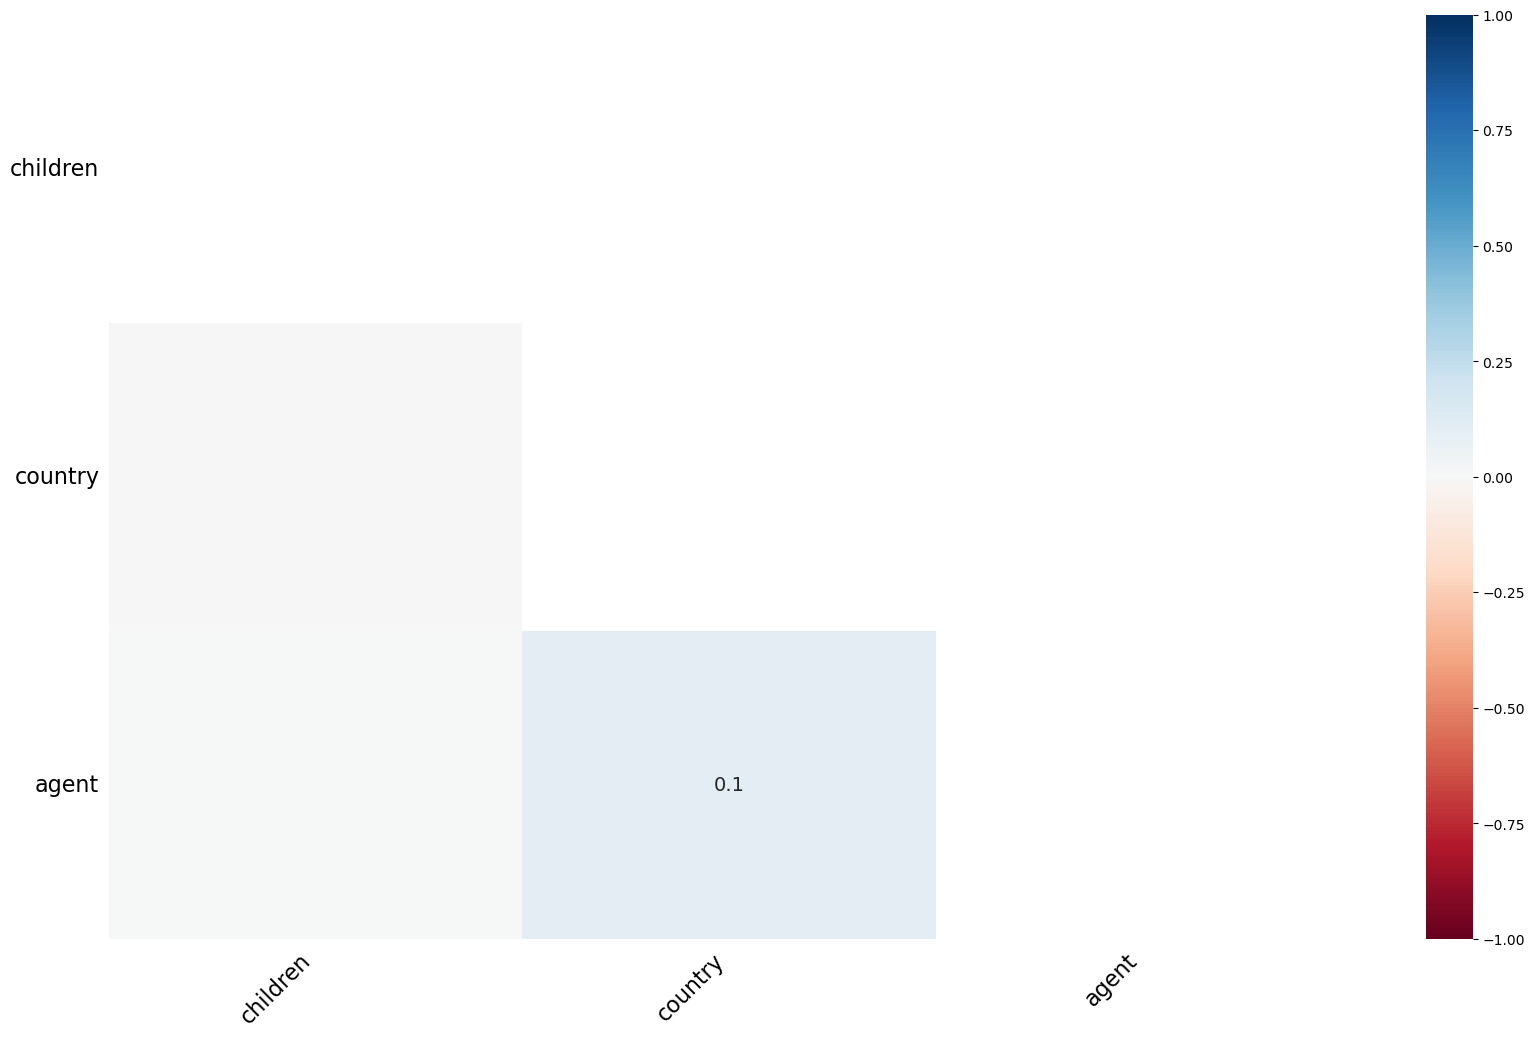

In [21]:
warnings.filterwarnings("ignore")

# generate the heatmap for missing data visualization
msno.heatmap(data)

# save the figure
plt.savefig("images/missing_data_heatmap.png")

In [22]:
# The agent column’s NaN values, which represent bookings made directly by customers without an agent, 
# are being replaced with 0.
data['agent'].fillna(0, inplace = True)

# Replacing null values with the most frequent value in below categorical features.
data['country'].fillna(data['country'].mode()[0], inplace = True)
data['children'].fillna(data['children'].mode()[0], inplace = True)

In [23]:
# Drop columns 'reservation_status', 'reservation_status_date', 'arrival_date_day_of_month', 'arrival_date_year' 
# will not impact analysis (Either they are correlated with target variable or not relevant predicting cancellations)
data.drop(['reservation_status', 'reservation_status_date', 'arrival_date_day_of_month', 'arrival_date_year'], 
          axis=1, inplace=True)

In [24]:
# Since the number of adults, babies, and children cannot all be zero, we can drop the rows where all of these 
# columns are zero.
filter = (data.children == 0) & (data.adults == 0) & (data.babies == 0)
data = data[~filter]

In [25]:
# Checking the count after dropping and filtering the data.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119210 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119210 non-null  object 
 1   is_canceled                     119210 non-null  int64  
 2   lead_time                       119210 non-null  int64  
 3   arrival_date_month              119210 non-null  object 
 4   arrival_date_week_number        119210 non-null  int64  
 5   stays_in_weekend_nights         119210 non-null  int64  
 6   stays_in_week_nights            119210 non-null  int64  
 7   adults                          119210 non-null  int64  
 8   children                        119210 non-null  float64
 9   babies                          119210 non-null  int64  
 10  meal                            119210 non-null  object 
 11  country                         119210 non-null  object 
 12  market_segment  

In [26]:
# Find list of continuous variables from a list of numerical variables.
def get_continuous_variables(numerical_variables, threshold=150):
    return [variable for variable in numerical_variables if len(df[variable].unique()) > threshold]

# Get the continuous variables
continuous_variables = get_continuous_variables(data.describe().columns)
continuous_variables

['lead_time', 'agent', 'adr']

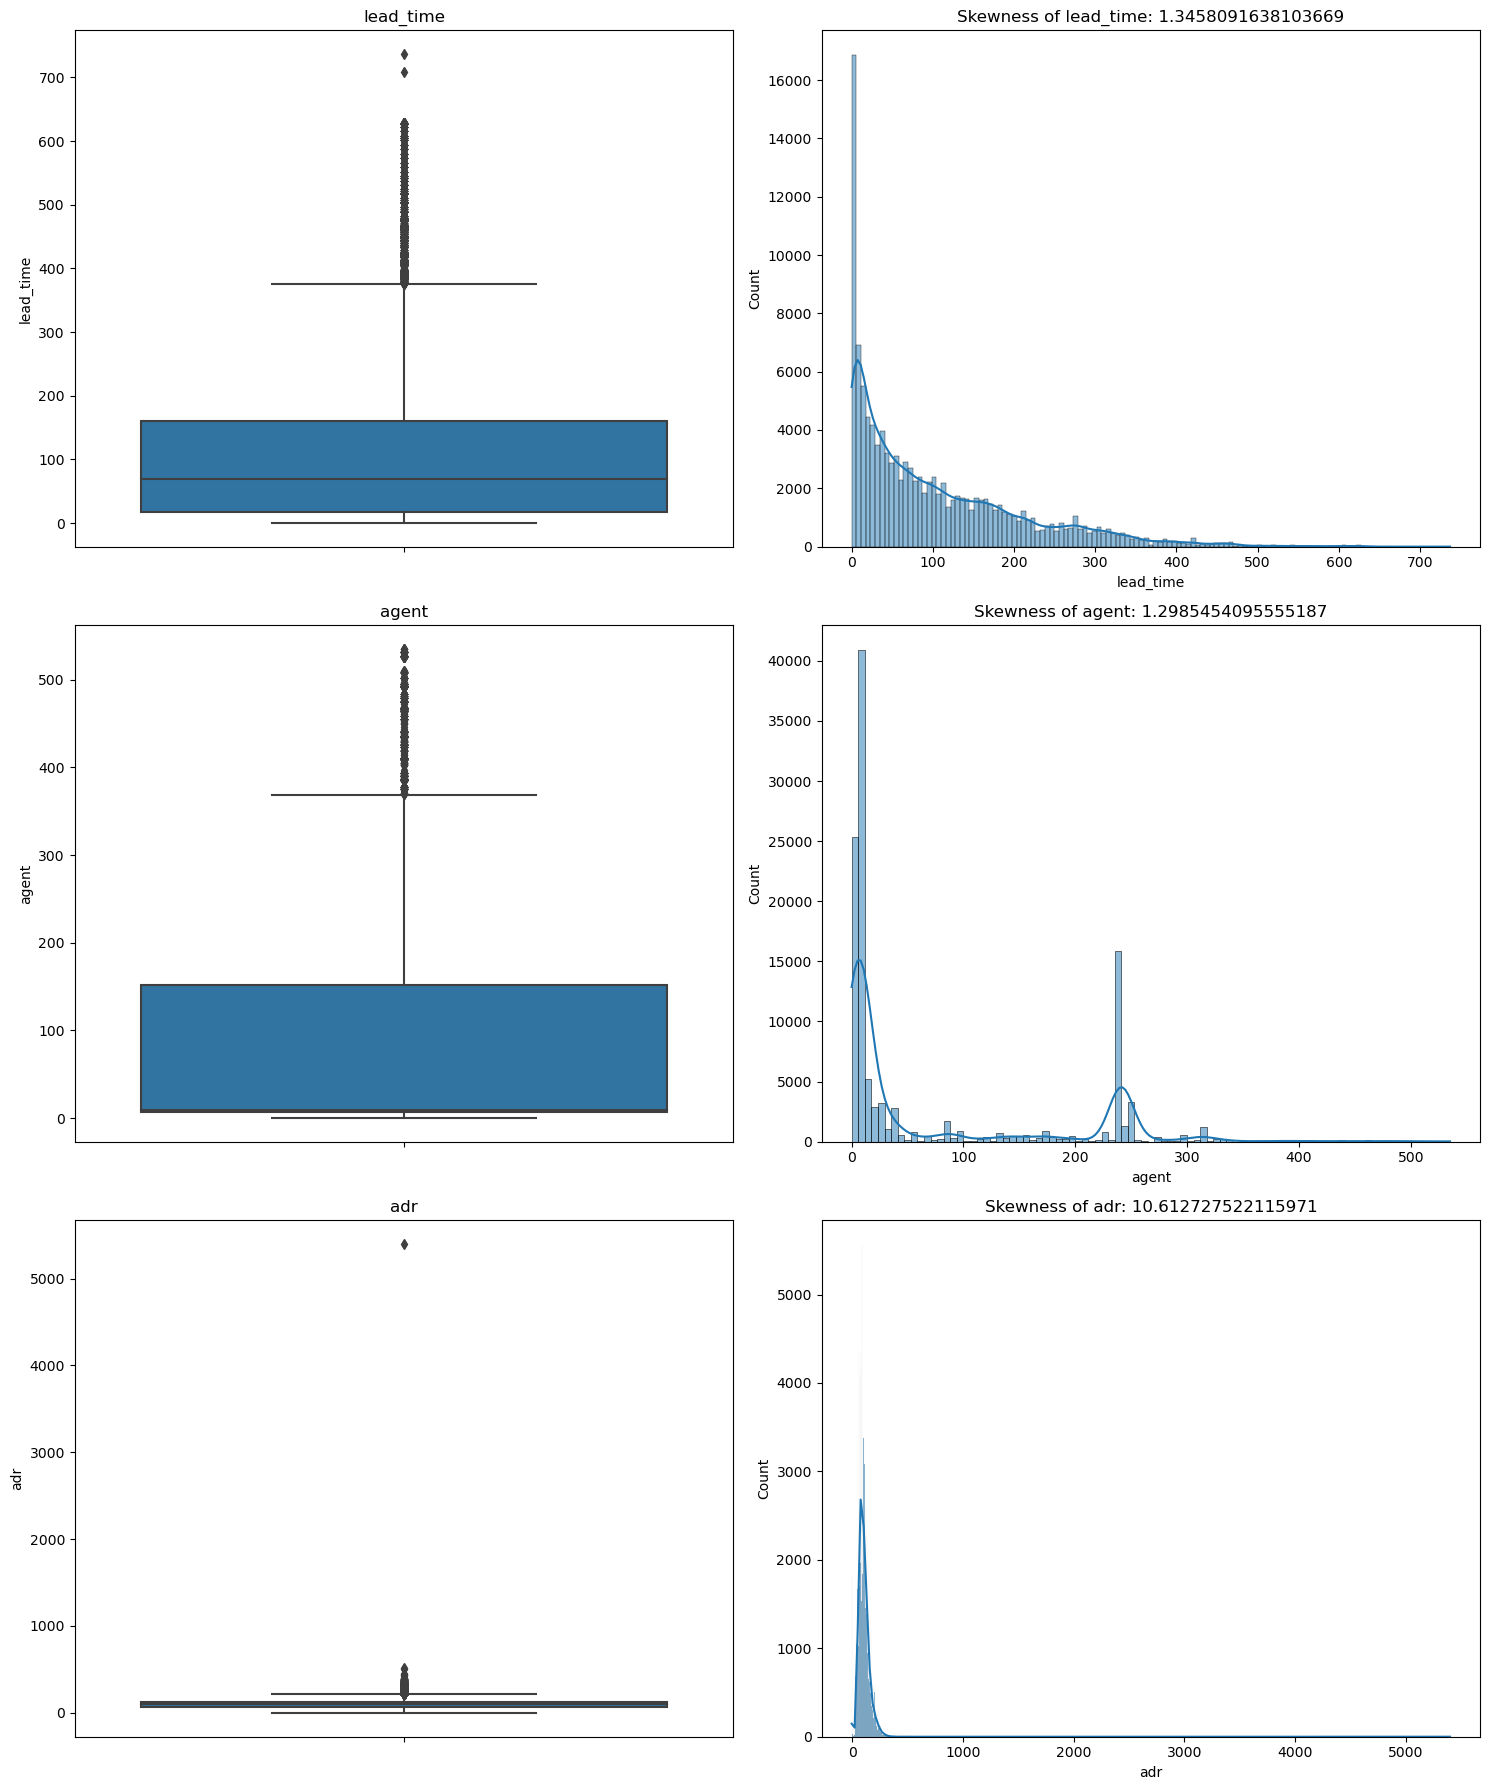

In [27]:
# Function that checks for outliers in a dataframe for a given list of continuous variables.
def check_for_outliers(odd_df, continuous_variables):
    
    fig, axes = plt.subplots(nrows=len(continuous_variables), ncols=2, figsize=(15, 6 * len(continuous_variables)))
    
    for i, col in enumerate(continuous_variables):

        # Boxplot shows the median, quartiles, and whiskers of the variable, 
        # as well as any outliers that are beyond the whiskers.
        sns.boxplot(y=col, data=odd_df, ax=axes[i, 0])
        axes[i, 0].set_title(f'{col}')
        axes[i, 0].set_ylabel(col)

        # Distribution plot shows the histogram and the kernel density estimate (KDE) of the variable.
        sns.histplot(odd_df[col], kde=True, ax=axes[i, 1])        
        axes[i, 1].set_title(f'Skewness of {col}: {odd_df[col].skew()}')
        axes[i, 1].set_xlabel(col)

    # Adjust layout
    plt.tight_layout()
    # Save the figure
    plt.savefig(f'{image_name}')
    plt.show()

image_name = "images/outliers_detection_and_distribution_analysis_for_continuous_variables.png"
check_for_outliers(data, continuous_variables)

### <font color='purple'>Observations:</font>
   - Outliers were detected in the ‘lead_time’ and ‘adr’ variables, but not in the ‘agent’ variable. 

In [28]:
# Removes outliers from a DataFrame using the Interquartile Range (IQR) method.
def remove_outliers_iqr(iqr_df, outlier_features):
    for col in outlier_features:
        # Calculate the IQR
        q1 = iqr_df[col].quantile(0.25)
        q3 = iqr_df[col].quantile(0.75)
        iqr = q3 - q1

        # Calculate the lower and upper limits
        lower_limit = q1 - 1.5 * iqr
        upper_limit = q3 + 1.5 * iqr

        # Remove outliers
        iqr_df.loc[iqr_df[col] > upper_limit, col] = upper_limit
        iqr_df.loc[iqr_df[col] < lower_limit, col] = lower_limit

    return iqr_df

# outlier features from above plot
outlier_features = ['lead_time','adr']

data = remove_outliers_iqr(data, outlier_features)

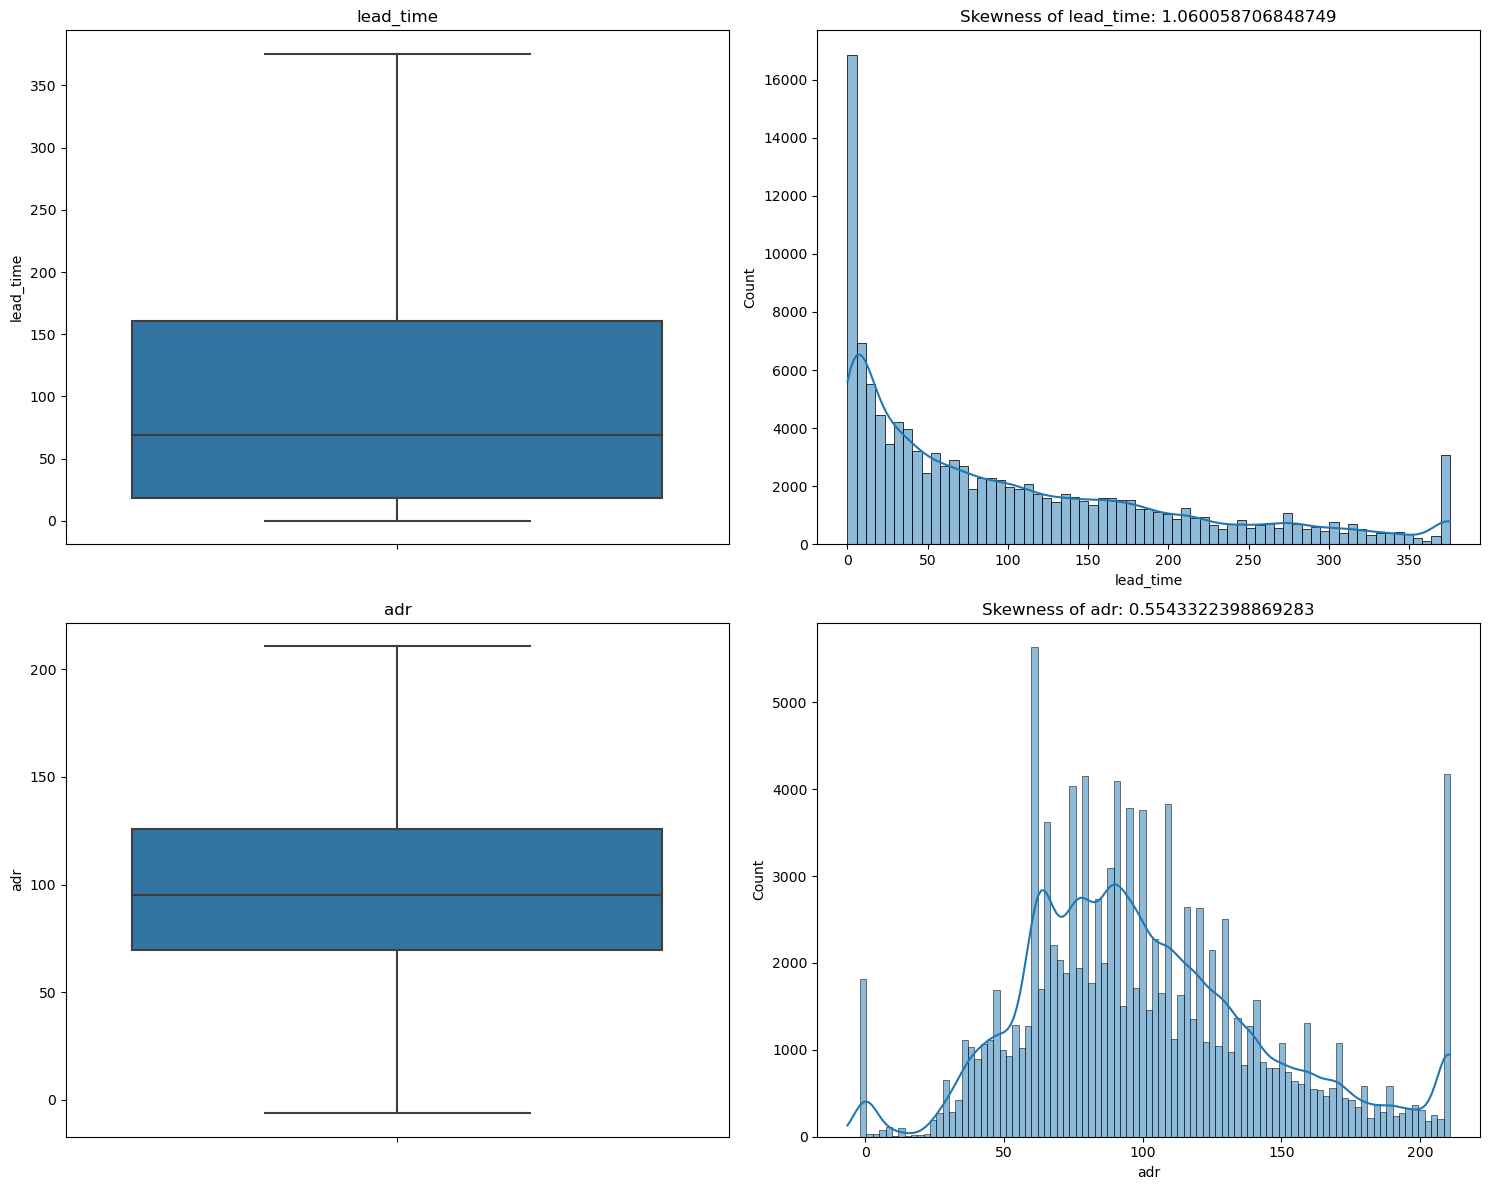

In [29]:
# Checking for outliers in the data after cleaning it.
image_name = "images/cleaned_and_normalized_data_for_continuous_variables.png"
check_for_outliers(data, outlier_features)

### <span style="color:#d35400">Data Wrangling & Feature Engineering:</span>

#### Feature engineering involves creating new features from the existing ones or transforming existing features to improve model performance.

In [30]:
# Agent and children should be integers, so converted from float to int data types.
data[['children','agent']]=data[['children','agent']].astype('int64')

In [31]:
# The ‘week night’ and ‘weekend night’ stays are being combined into a new ‘total_stays’ variable.
# Calculate the total stays
data['total_stays'] = data[['stays_in_weekend_nights', 'stays_in_week_nights']].sum(axis=1).astype('int64')

# The ‘adults’, ‘children’, and ‘babies’ fields are being summed up into a new ‘total_guests’ field.
data['total_guests'] = data[['adults', 'children', 'babies']].sum(axis=1).astype('int64')

# The ‘children’, and ‘babies’ fields are being summed up into a new ‘total_children’ field.
data['total_children'] = data[['children', 'babies']].sum(axis=1).astype('int64')

# The ‘reserved_room_assigned’ variable is being created to indicate whether the ‘reserved_room_type’ is the same as 
# the ‘assigned_room_type’.
data['reserved_room_assigned'] = (data['reserved_room_type'] == data['assigned_room_type']).astype(int)

# Dropping the columns to eliminate redundancy and prevent duplication of information,
data.drop(['stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies',
           'reserved_room_type', 'assigned_room_type'], axis=1, inplace=True)

In [32]:
# Reset the index of new features added.
data.reset_index(drop=True, inplace=True)

### <span style="color:#d35400">Data Visualization:</span>

In [33]:
# Exclude the high cardinality features
excluded_features = [var for var in data.columns if data[var].nunique() > 15]

# Obtain the target features
target_features = [var for var in data.columns if var not in excluded_features]

target_features

['hotel',
 'is_canceled',
 'arrival_date_month',
 'meal',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'deposit_type',
 'customer_type',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'total_guests',
 'total_children',
 'reserved_room_assigned']

In [34]:
def annotate_percentage_on_bar(patch, axes):
    total = sum(patch.get_height() for patch in axes.patches) / 100
    percent = round((patch.get_height() / total), 2)
    x, y = patch.get_x() + patch.get_width() / 2, patch.get_height()
    axes.annotate(f'{percent}%', (x, y), ha='center', va='bottom')

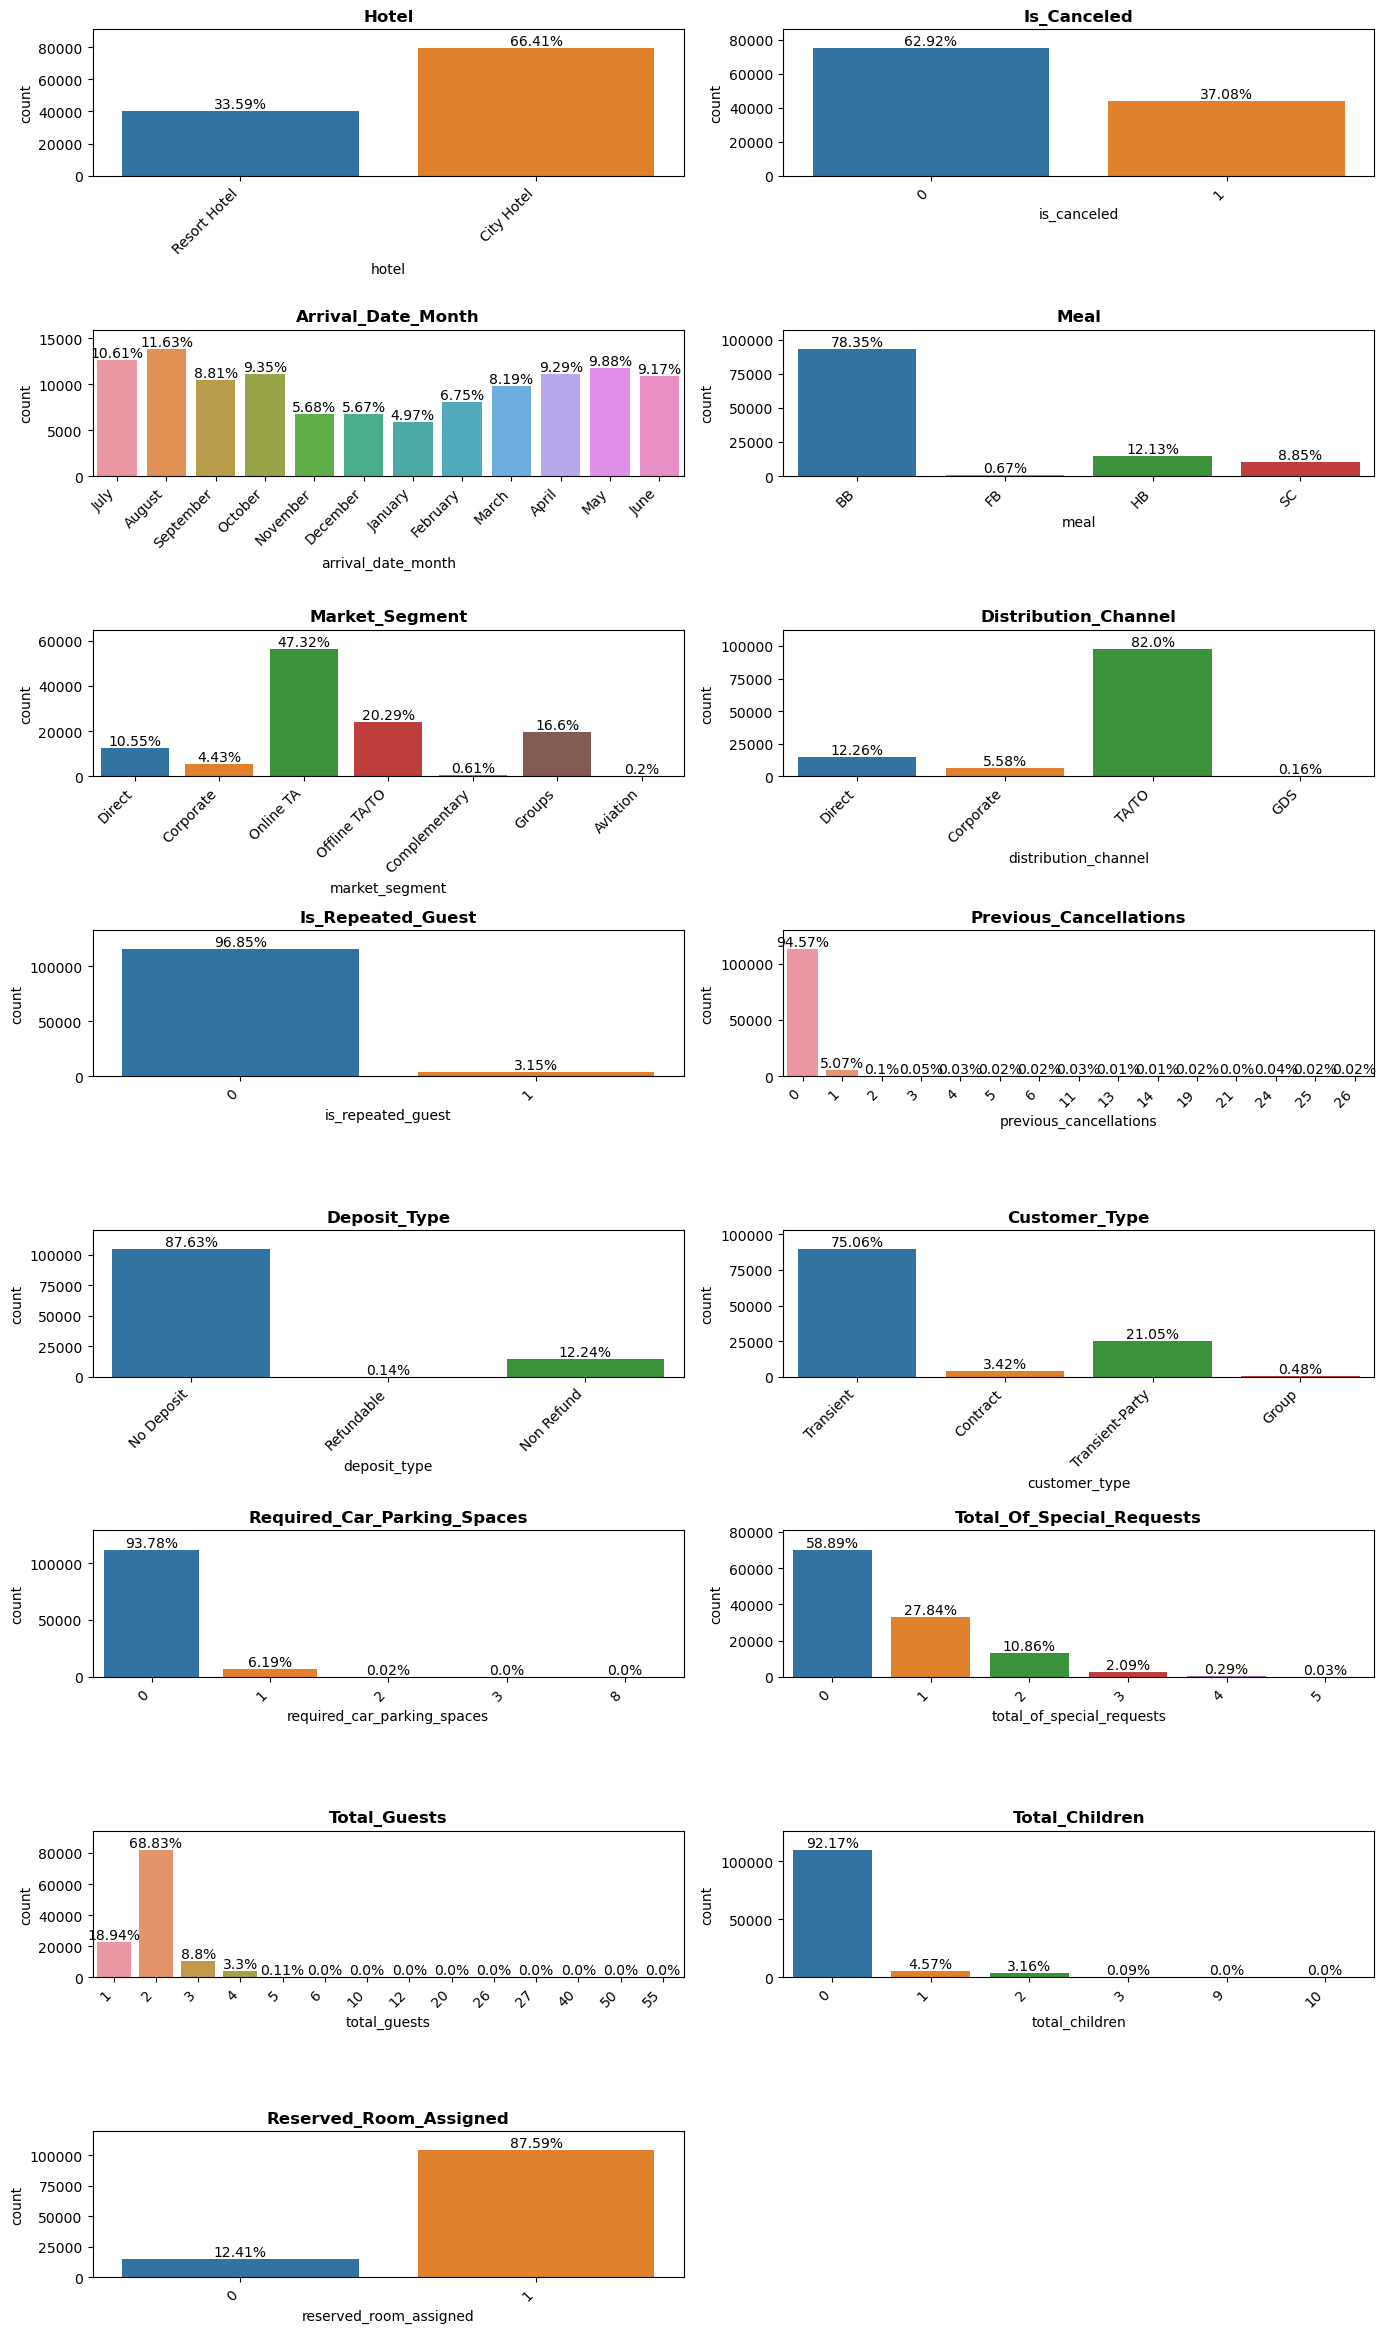

In [35]:
# Plotting the countplots for each variable in target_features
plt.figure(figsize=(14, 44))

for n, var in enumerate(target_features):
    axes = plt.subplot(len(target_features), 2, n + 1)
    sns.countplot(x=data[var]).margins(y=0.15)
    # Rotate x-axis tick labels by 45 degrees
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'{var.title()}', weight='bold')
    
    for patch in axes.patches:
        annotate_percentage_on_bar(patch, axes)

# Save the figure
plt.savefig("images/annotated_countplots.png")
plt.tight_layout()
plt.show()

### <font color='purple'>Observations:</font>
   - City hotels are more popular than resorts.
   - Most bookings are not canceled (63%), but almost one-third of all reservations are canceled (37%).
   - The most popular months for bookings are August and July, and the least popular months are November, December, and January.
   - Most bookings are made through the online platform, and the top distribution channel is 'TA/TO'.
   - Most bookings are made by new customers, and very few customers visit again (3.15%).
   - 93.78% of customers do not require parking spaces.
   - 12.41% of customers were not assigned the rooms they reserved.
   - Most reservations are made for two people (69%), but few guests bring their families (9%).

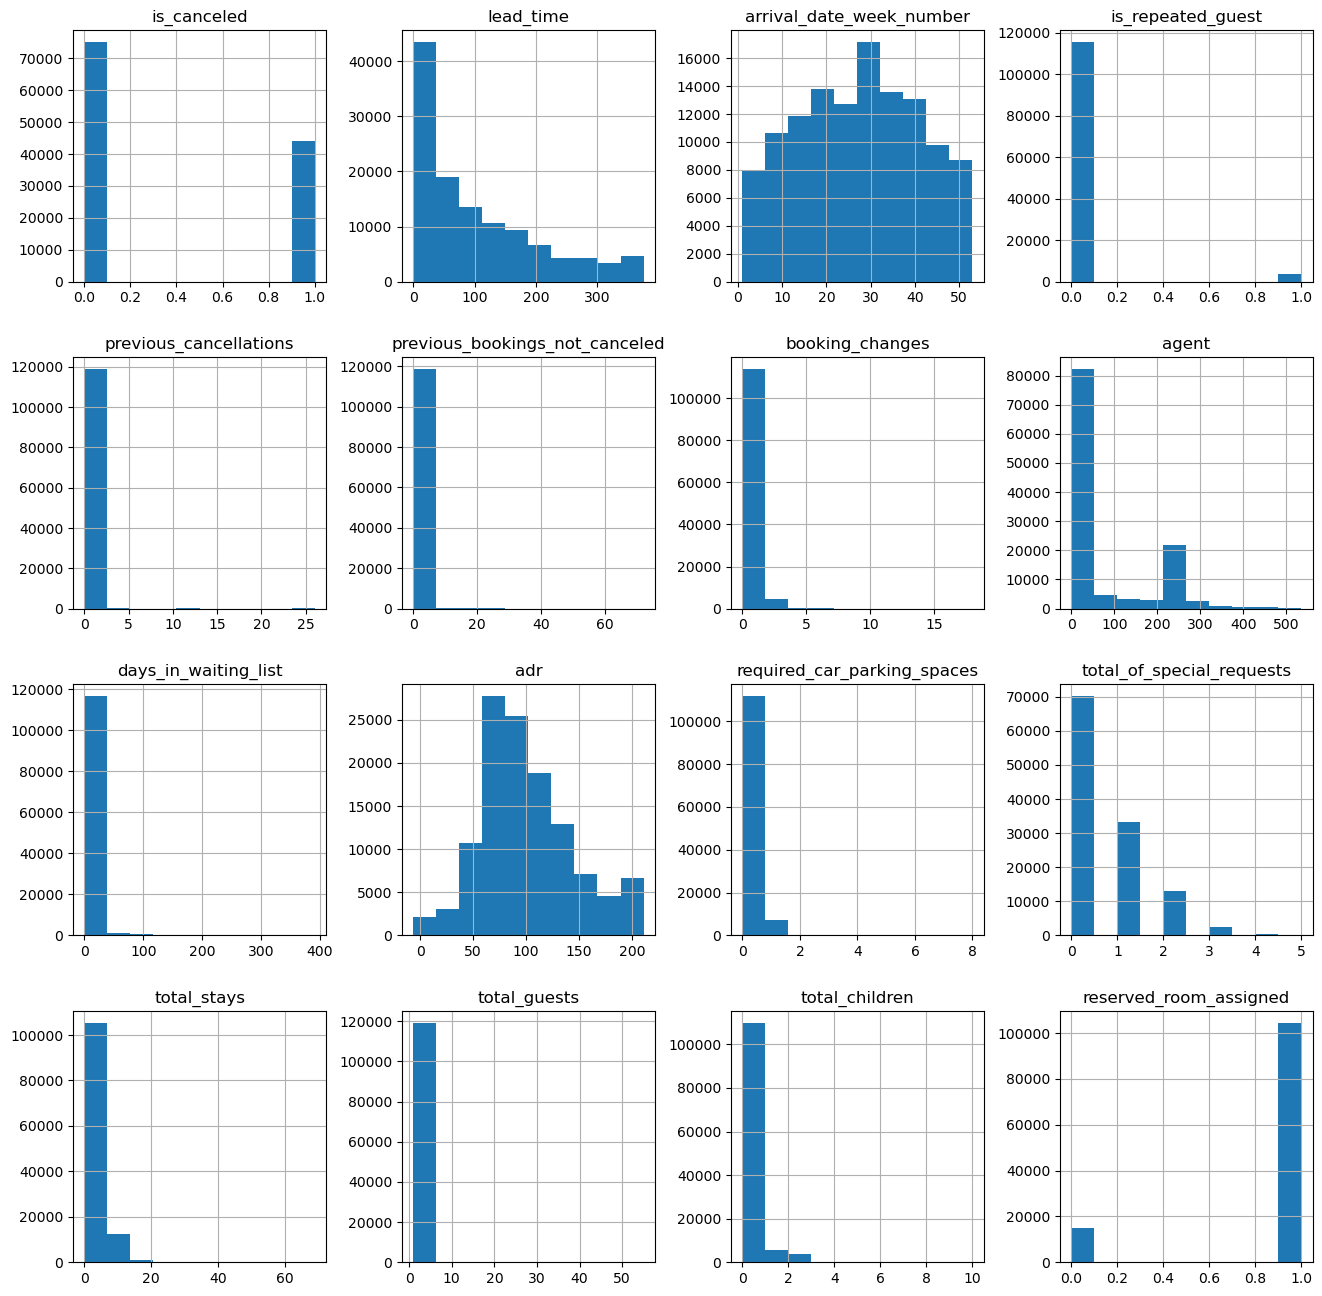

In [36]:
numerical_features = data.describe().columns
_ = data.hist(column=numerical_features, figsize = (16,16))
# Save the plot to a file (e.g., in PNG format)
plt.savefig('images/histogram_plot.png')

### <font color='purple'>Observations:</font>
   - Cancellations peak during summer months (arrival_date_week_number 20-30).
   - Shorter lead times (median 10 days) are associated with higher cancellation rates compared to longer lead times (median 20 days).
   - Repeat guests are less likely to cancel, with a median of 0 previous_cancellations for non-canceled bookings compared to 1 for canceled bookings.
   - Bookings with more changes (median booking_changes: 2) are more likely to be canceled compared to those with fewer changes (median booking_changes: 1).
   - Agent-assisted bookings have a higher likelihood of cancellation (median agent: 1 for canceled bookings, 0 for non-canceled bookings).
   - Longer days_in_waiting_list (median 5 days) increase the likelihood of cancellation compared to shorter waiting times (median 2 days).
   - Higher total_of_special_requests is associated with a lower likelihood of cancellation.
   - Canceled bookings tend to have lower average daily rates (adr) compared to non-canceled bookings.
   - Higher required_car_parking_spaces are associated with increased cancellation likelihood.
   - Bookings with fewer total_stays, total_guests, total_children, and reserved_room_assigned are more likely to be canceled.

## <span style="color:#d35400">What deposit type has the highest percentage of bookings canceled?</span>

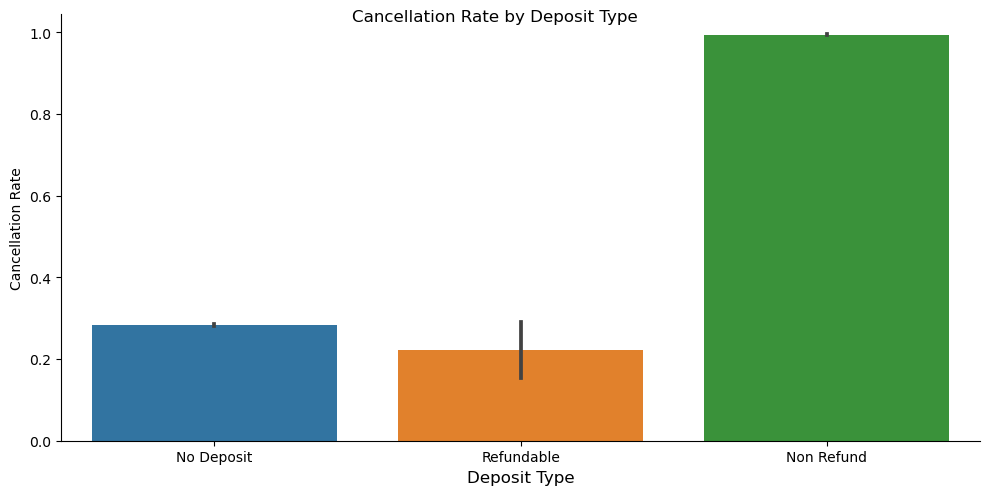

In [37]:
# Create catplot for Cancellation rate by Deposit
sns.catplot(x='deposit_type', y='is_canceled', kind='bar', data=df, height=5, aspect=2)
plt.suptitle('Cancellation Rate by Deposit Type')
plt.xlabel('Deposit Type', fontsize=12) 
plt.ylabel('Cancellation Rate');
plt.savefig("images/cancellation_rate_by_deposit_type.png")  

### <font color='purple'>Observations:</font>
   - More people cancel when they pay a full deposit that they can't get back. We need to look more closely at these bookings to understand why.

## <span style="color:#d35400">Does the length of lead time (the number of days between booking and arrival) affect the likelihood of booking cancellations?</span>

<Figure size 1200x800 with 0 Axes>

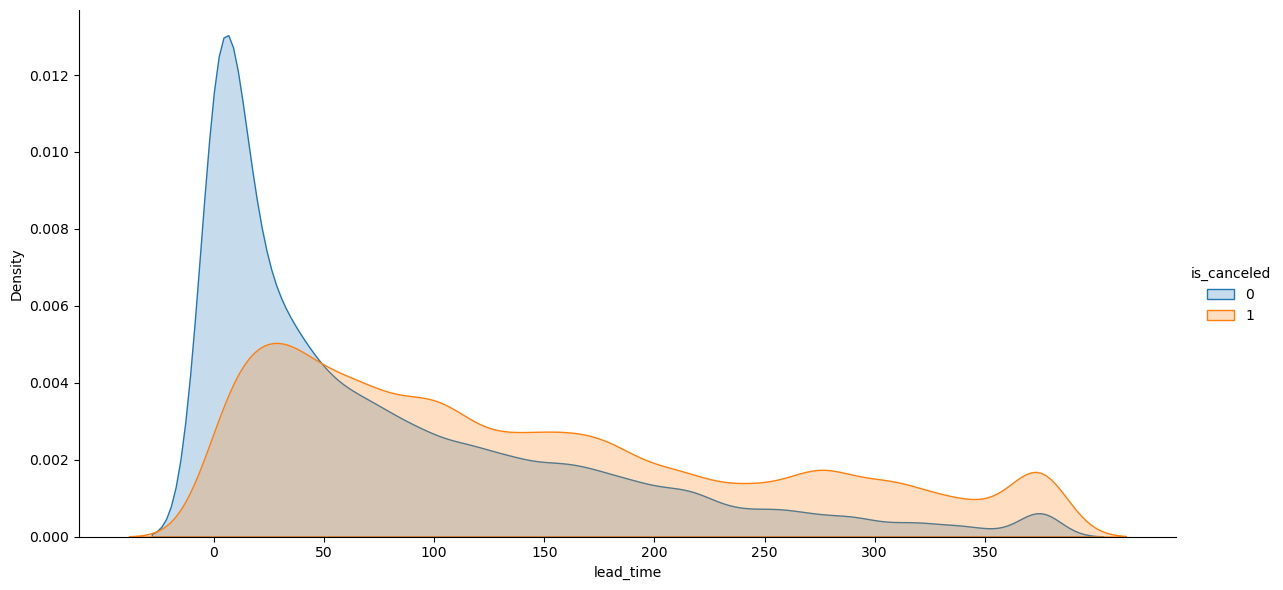

In [38]:
warnings.filterwarnings("ignore")

plt.figure(figsize=(12, 8))
g = sns.FacetGrid(data, hue='is_canceled', height=6, aspect=2)

# Map the kdeplot function to the DataFrame
g.map_dataframe(sns.kdeplot, 'lead_time', fill=True)

# Add a legend
g.add_legend()

# Set x-axis ticks at intervals of 50
plt.xticks(range(0, int(data['lead_time'].max()) + 1, 50))

# Save the figure
plt.savefig("images/booking_cancellations_by_length_of_stay.png")

# Display the plot
plt.show()

### <font color='purple'>Observations:</font>
   - There is a clear negative correlation between lead time and cancellation rate.
   - The cancellation rate is highest for bookings that are made within a few days of the arrival date.
   - The cancellation rate is lowest for bookings that are made more than a month in advance.

## <span style="color:#d35400">Does the absence of a reserved room assignment contribute to booking cancellations?</span>

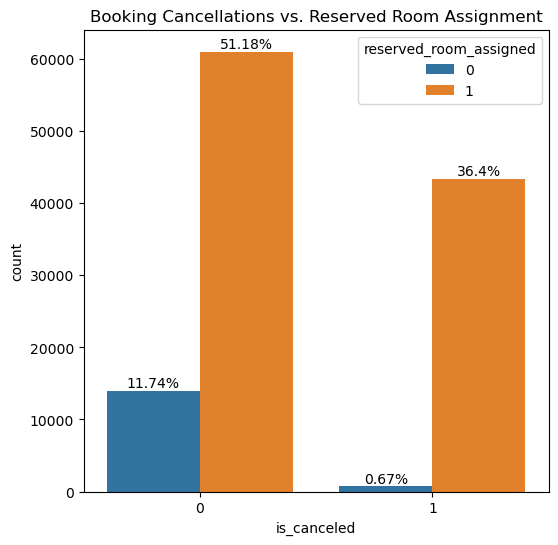

In [39]:
# Create a figure
fig = plt.figure(figsize=(6, 6))


ax = sns.countplot(x=data['is_canceled'], hue=data['reserved_room_assigned'])
ax.set_title('Booking Cancellations vs. Reserved Room Assignment')
# Annotate the percentage on each bar
for patch in ax.patches:
    annotate_percentage_on_bar(patch, ax)

# Save the figure
plt.savefig("images/booking_cancellations_vs_reserved_room_assignment.png")

# Display the plot
plt.show()

### <font color='purple'>Observations:</font>
   - The cancellation rate is 51.18%. This means that more than half of all bookings are cancelled.
   - The reserved room assignment rate is 36.4%. This means that slightly more than one-third of all bookings result in a reserved room assignment.
   - The remaining 11.74% of bookings are either cancelled or not yet assigned to a room.
   - Less than 1% of customers cancelled their booking because a reserved room was not assigned to them.

## <span style="color:#d35400">How does the hotel type affect the percentage of canceled bookings for different guest categories?</span>

In [40]:
# Using copy of the dataframe for visualizations
data_df = data.copy()

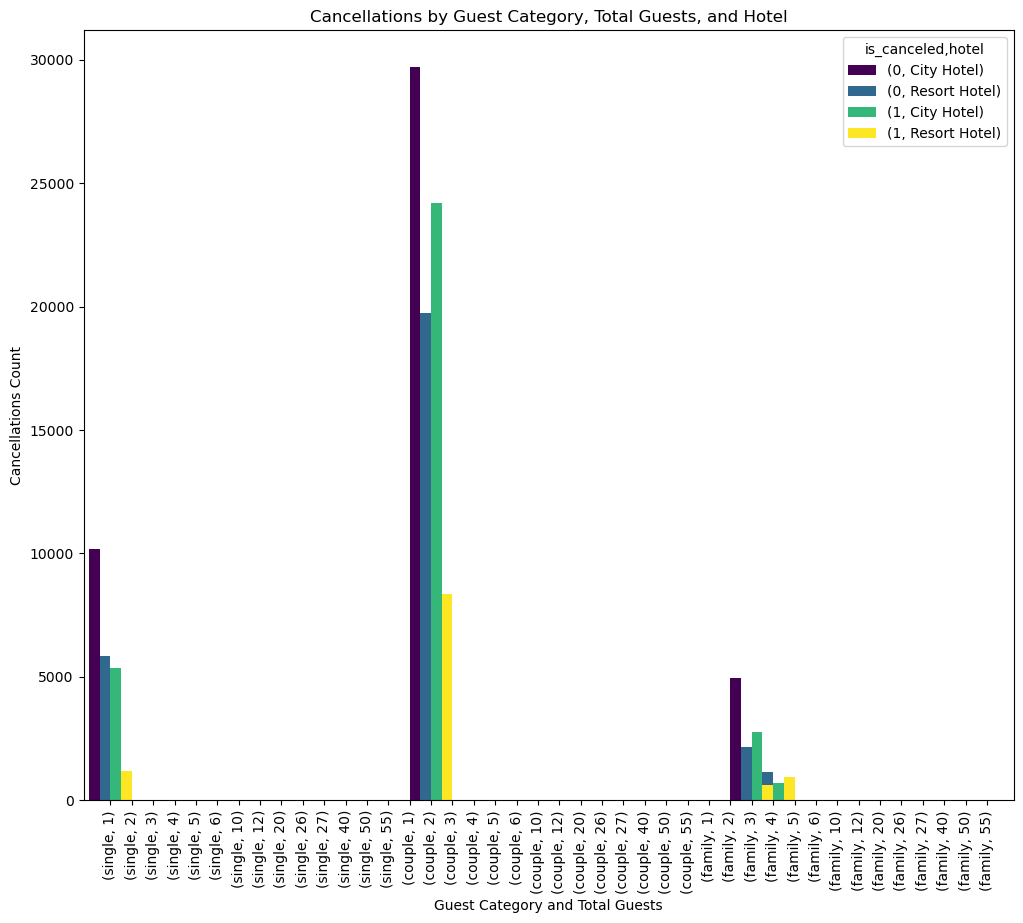

In [41]:
# Create a new column 'guest_category' based on the total number of guests
data_df['guest_category'] = pd.cut(data_df['total_guests'], bins=[0, 1, 2, float('inf')], labels=['single', 'couple', 'family'])

# Create a pivot table with guest category, total guests, hotel, and cancellation count
pivot_data = data_df.pivot_table(index=['guest_category', 'total_guests'], columns=['is_canceled', 'hotel'], 
                                 aggfunc='size', fill_value=0)

# Plot the pivot table as a grouped bar chart
pivot_data.plot(kind='bar', figsize=(12, 10), width=2.0, colormap='viridis')

# Add labels and title
plt.xlabel('Guest Category and Total Guests') 
plt.ylabel('Cancellations Count') 
plt.title('Cancellations by Guest Category, Total Guests, and Hotel')

# Save the figure
plt.savefig("images/cancellations_by_guest_category_total_guests_and_hotel.png")

plt.show()

### <font color='purple'>Observations:</font>
   - The most common guest category is single (total_guests=1), followed by couple (total_guests=2), and family (total_guests=3 or more).
   - The cancellation rate is higher for larger group of guests.
   - The cancellation rate is higher for resort hotels than for city hotels.

## <span style="color:#d35400">Do more expensive hotels have more cancellations?</span>

In [42]:
data_df["adr_pp"] = data_df["adr"] / data_df["total_guests"]

# Convert 'arrival_date_month' to categorical with custom ordering
month_order = list(calendar.month_name)[1:]
data_df['arrival_date_month'] = pd.Categorical(data_df['arrival_date_month'], categories=month_order, ordered=True)

In [43]:
# Count the number of cancelled and not cancelled bookings for each month
cancelled_bookings = data_df[data_df['is_canceled'] == 1]
not_cancelled_bookings = data_df[data_df['is_canceled'] == 0]

cancelled_bookings_by_month = cancelled_bookings['arrival_date_month'].value_counts().reset_index()
cancelled_bookings_by_month.columns = ['arrival_date_month', 'cancelled_bookings']

not_cancelled_bookings_by_month = not_cancelled_bookings['arrival_date_month'].value_counts().reset_index()
not_cancelled_bookings_by_month.columns = ['arrival_date_month', 'not_cancelled_bookings']

# Create a new dataframe to store the number of cancelled and not cancelled bookings for each month
df_bookings_by_month = pd.merge(cancelled_bookings_by_month, not_cancelled_bookings_by_month, on='arrival_date_month', how='outer')

# Convert 'arrival_date_month' to categorical with custom ordering
df_bookings_by_month['arrival_date_month'] = pd.Categorical(df_bookings_by_month['arrival_date_month'], categories=month_order, ordered=True)

# Sort the DataFrame by the categorical 'arrival_date_month' column
df_bookings_by_month = df_bookings_by_month.sort_values(by='arrival_date_month')

# Plot the number of cancelled and not cancelled bookings for each month
fig = px.line(df_bookings_by_month, x='arrival_date_month', y=['cancelled_bookings', 'not_cancelled_bookings'],
              title='Number of Bookings Cancelled and Not Cancelled Over the Months',
              template='plotly_dark')

fig.write_image("images/bookings_cancelled_vs_not_cancelled_by_month.png", format="png", width=800, height=600)

# Show the plot
fig.show()

### <font color='purple'>Observations:</font>
   - August has the most expensive and canceled hotel bookings.

## <span style="color:#d35400">How do hotel prices change depending on the month and the number of guests?</span>

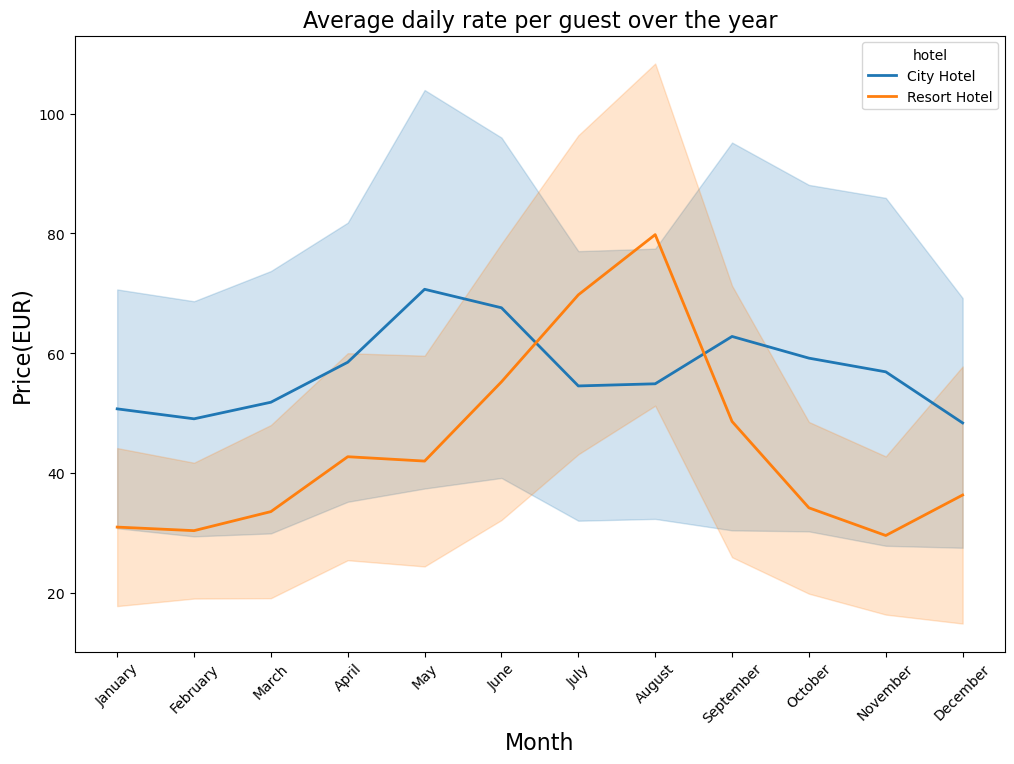

In [44]:
# Sort the DataFrame by the categorical 'arrival_date_month' column
data_df = data_df.sort_values(by='arrival_date_month')

# Create a line plot of room price per night and person over the year
plt.figure(figsize=(12, 8))
sns.lineplot(x="arrival_date_month", y="adr_pp", hue="hotel", data=data_df,
             hue_order=["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2, 2))
plt.title("Average daily rate per guest over the year", fontsize=16)
plt.xlabel("Month", fontsize=16)
 # Adjust the rotation angle for better visibility
plt.xticks(rotation=45)
plt.ylabel("Price(EUR)", fontsize=16)

# Save the image
plt.savefig("images/average_daily_rate_line_plot.png")
# Show the plot            
plt.show()

### <font color='purple'>Observations:</font>
   - The Resort hotel costs more in August because it is summer in Portugal. The City hotel charges less and is priciest in May and September when it is spring and autumn.

In [45]:
categorical_features = data.describe(include=["object"]).columns

## <span style="color:#d35400">What are the top 10 countries contributing the most guests to these hotels?</span>

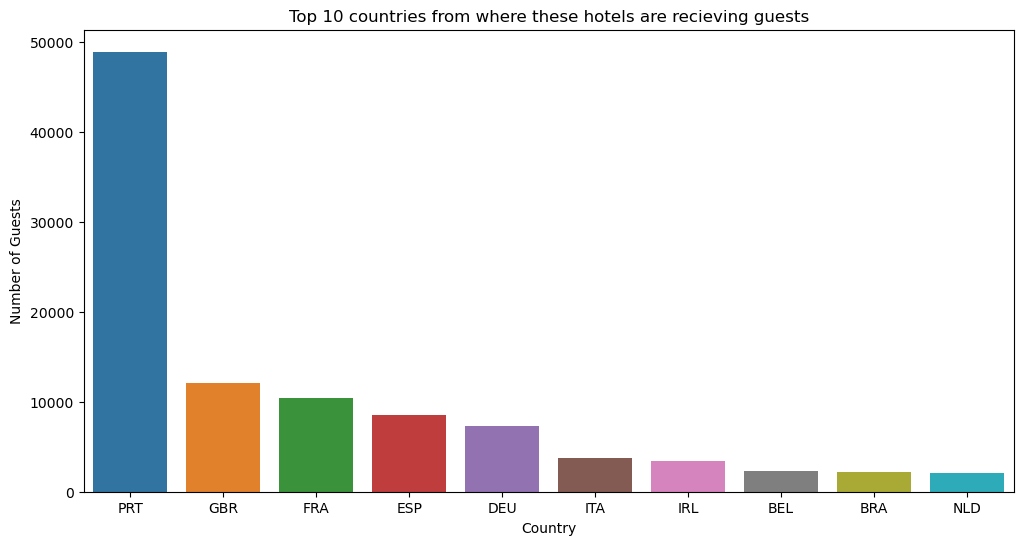

In [46]:
# Get the top 10 countries from where the hotels are receiving guests
top_countries_with_codes = data['country'].value_counts().head(10)

# Encode the country codes
country_codes_encoded = pd.factorize(top_countries_with_codes.index)[0]

# Create a bar plot of the top 10 countries
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=country_codes_encoded, y=top_countries_with_codes, ax=ax)

# Set the x-axis labels to the top 10 countries
ax.set_xticks(ticks=country_codes_encoded, labels=top_countries_with_codes.index.to_list())

# Set the title of the plot
ax.set_title('Top 10 countries from where these hotels are recieving guests')
ax.set_xlabel('Country')
ax.set_ylabel('Number of Guests')

# Save the image
plt.savefig("images/top10_countries_received_guests.png")
# Show the plot
plt.show()

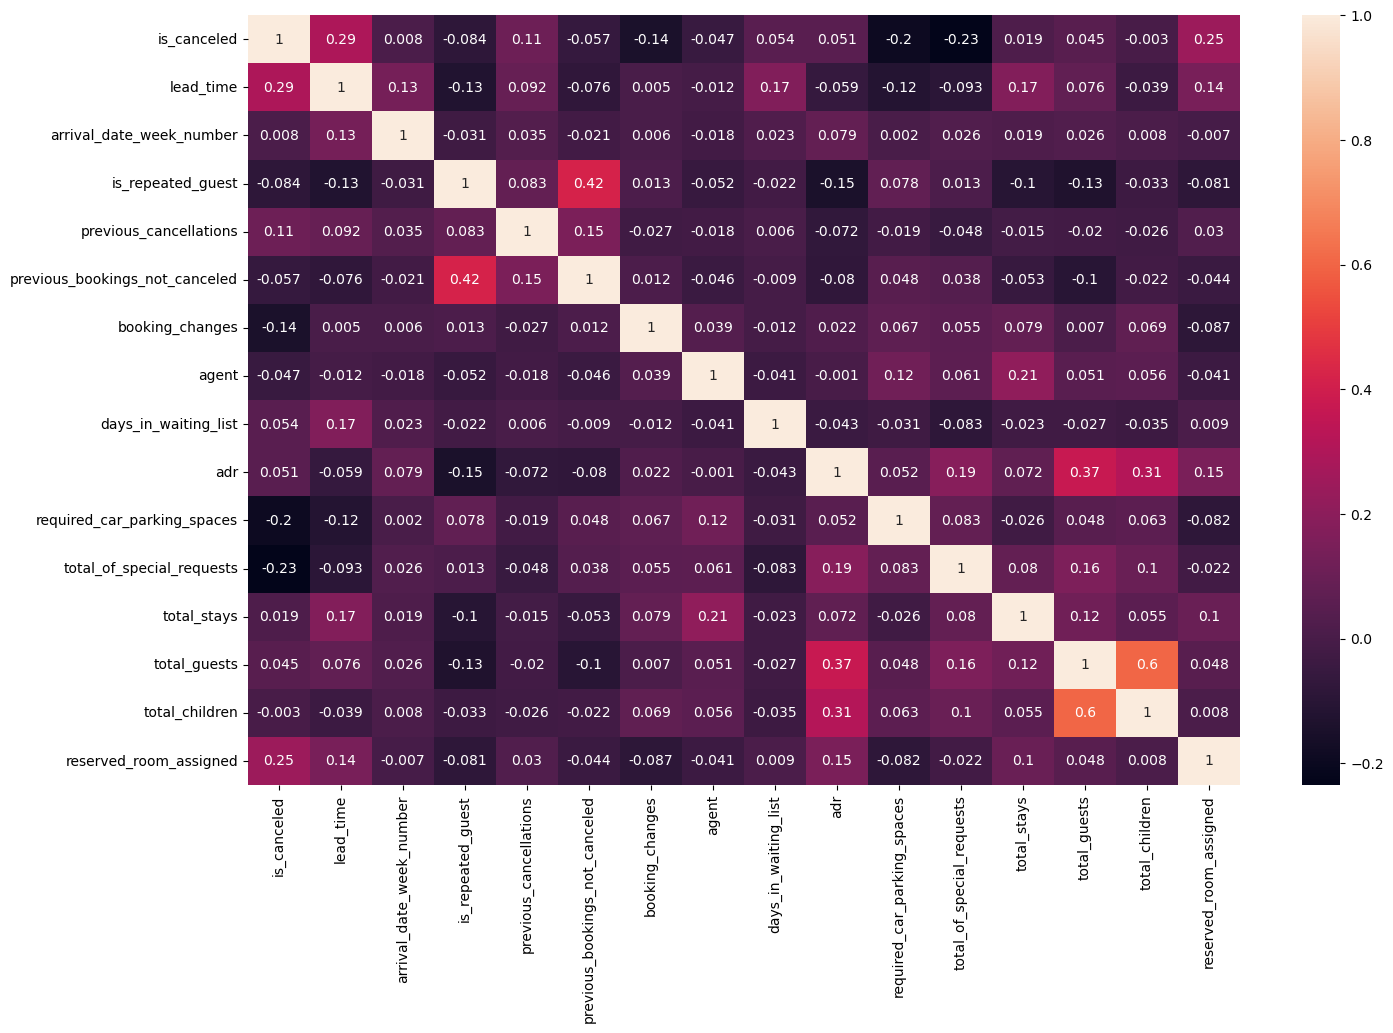

In [47]:
# Explore relationships between variables
plt.figure(figsize=(16, 10))

correlation_matrix = data.corr(numeric_only=True).round(3)
sns.heatmap(correlation_matrix, annot=True)

# Save the image
plt.savefig("images/numeric_variables_heatmap.png")
# Show the plot 
plt.show()

### <font color='purple'>Observations:</font>

   - The following features are most likely to be related to each other:

        - Lead time and arrival date week number (0.13)
        - Lead time and booking changes (0.05)
        - Lead time and agent (0.005)
        - Lead time and days in waiting list (0.17)
        - Arrival date week number and booking changes (0.035)
        - Arrival date week number and agent (0.018)
        - Booking changes and agent (0.039)
        - Days in waiting list and required car parking spaces (0.079)
        - Required car parking spaces and total of special requests (0.19)
        - Total of special requests and total guests (0.072)
        - Total of special requests and total children (0.055)
        - Total guests and total children (0.6)

        > It indicates that guests who book their reservations early are more likely to arrive during the week, make changes to their booking, and stay at a hotel that is managed by a certain agent. 
        > Guests who arrive during the week are more likely to make changes to their booking and stay at a hotel that is managed by a certain agent. 
        > Guests who spend a lot of time on the waiting list are more likely to require a car parking space. 
        > Guests who require a car parking space are more likely to make a lot of special requests. 
        > Guests who make a lot of special requests are more likely to stay in a hotel with more guests and more children. 
        > Hotels with more guests are also more likely to have more children.

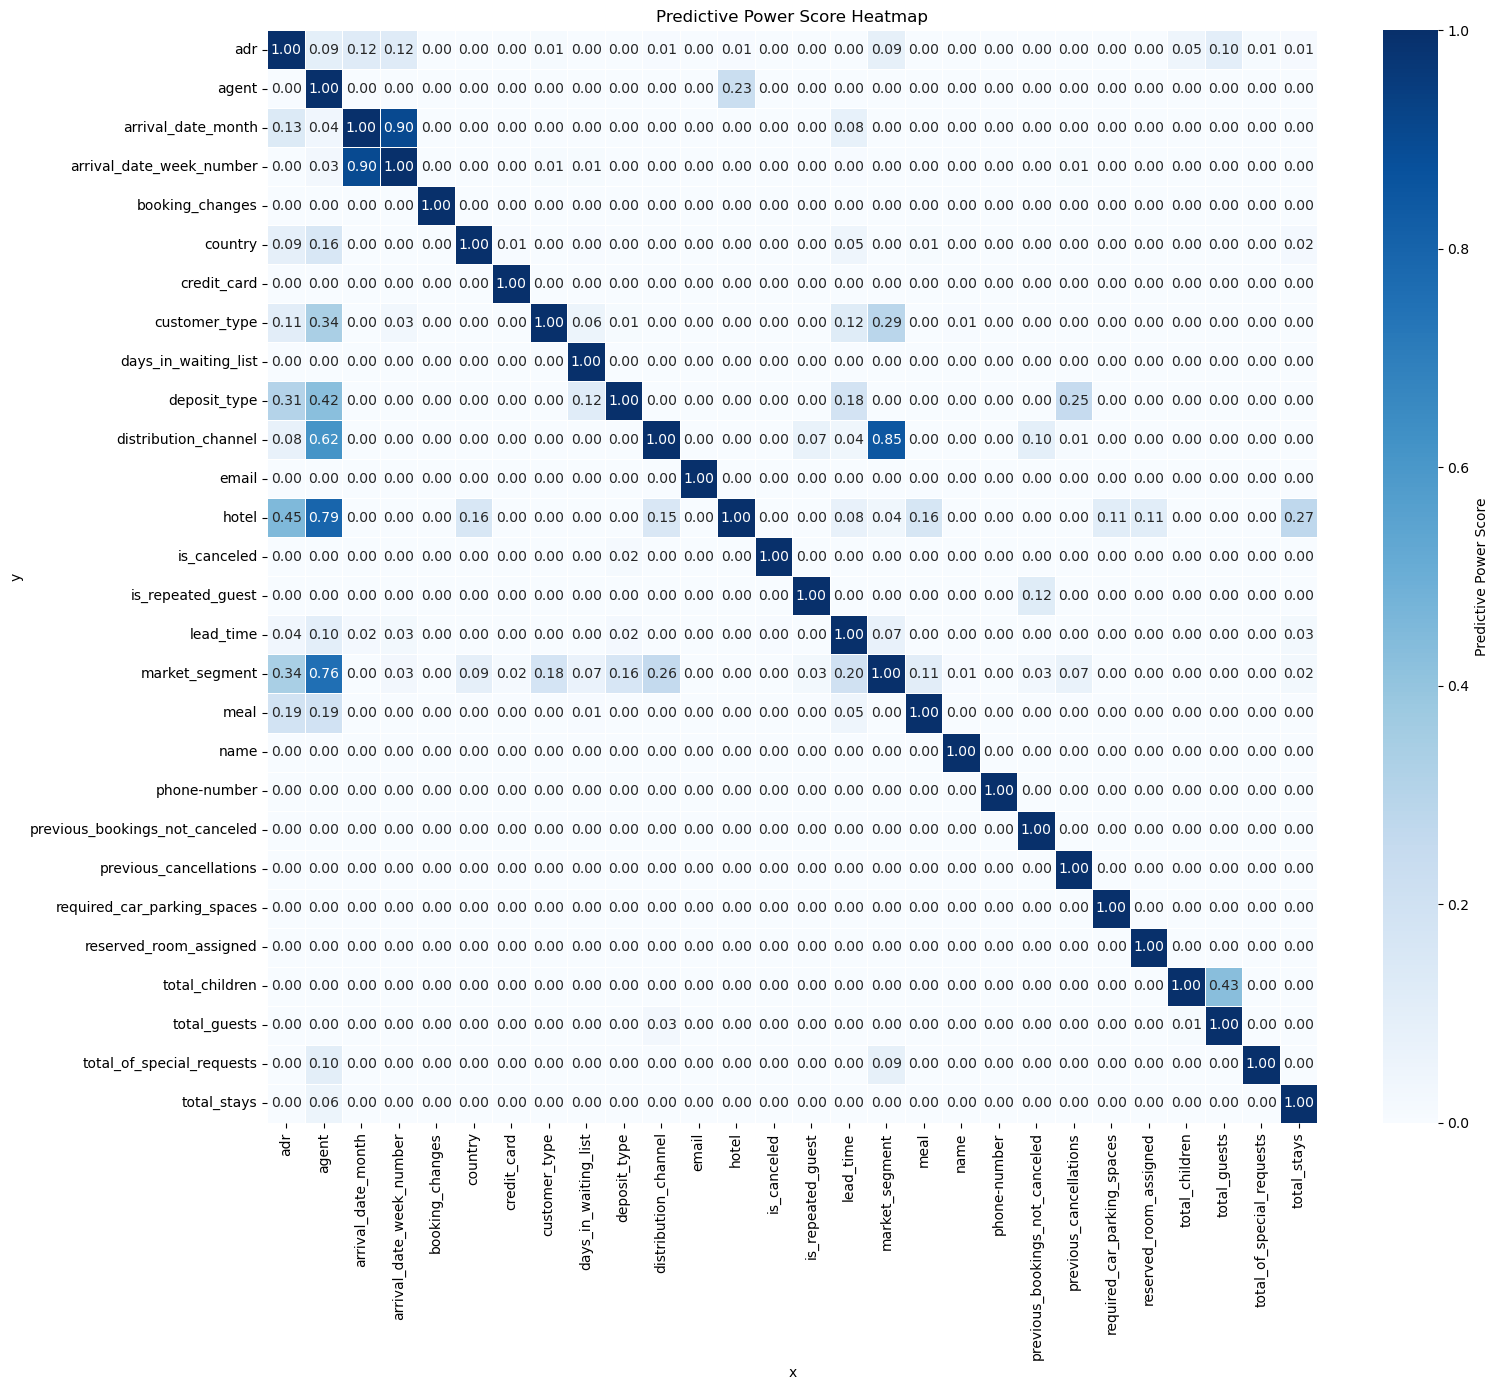

CPU times: user 9min 22s, sys: 885 ms, total: 9min 23s
Wall time: 9min 23s


In [48]:
%%time
def plot_pps_heatmap(data):
    
    matrix = pps.matrix(data)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

    plt.figure(figsize=(16, 14))
    sns.heatmap(matrix, vmin=0, vmax=1, cmap="Blues", fmt=".2f", linewidths=0.5, annot=True, 
                cbar_kws={'label': 'Predictive Power Score'})
    plt.title('Predictive Power Score Heatmap')
    plt.savefig(f'{image_name}')
    plt.tight_layout()
    plt.show()
    
    
image_name = "images/predictive_power_score_heatmap.png"
# Plot Predictive Power Score (PPS) to measure the predictive power of one column or variable on 
# another column or variable in the dataset.
plot_pps_heatmap(data)

### <font color='purple'>Observations:</font>        
   - The following features are most likely to be related to each other:
   
        - Previous cancellations and total of special requests (0.8)
        - Previous cancellations and is repeated guest (-0.6)
        - Market segment and country (0.85)
        - Market segment and hotel (0.79)
        - Total guests and reserved room assigned (1.0)
     
        > It indicates that guests who have cancelled reservations in the past are more likely to make a lot of special requests and are less likely to be repeat guests. 
        > Guests who are from a certain market segment are more likely to stay at a certain hotel in a certain country. 
        > The number of guests staying in a room is perfectly correlated with whether or not a room has been assigned.
        

   - In terms of cancellations, the following features have the highest predictive power:

        - Previous cancellations (0.2)
        - Total of special requests (0.4)
        - Is repeated guest (-0.6)

        > It indicates that guests who have cancelled reservations in the past are more likely to cancel their current reservation. 
        > Guests who make a lot of special requests are also more likely to cancel their reservation. 
        > Repeat guests are less likely to cancel their reservation.


In [49]:
# Let's check whether the dataset is balanced or imbalanced
data['is_canceled'].value_counts()

0    75011
1    44199
Name: is_canceled, dtype: int64

### <font color='purple'>Observations:</font>
   - The imbalance ratio is greater than 10%, the dataset is considered to be imbalanced

In [50]:
# Apply Label Encoding to categorical features
label_encoder = LabelEncoder()
# Label Encoding converts categorical labels into numerical format, allowing algorithms to process them. 
data[categorical_features] = data[categorical_features].apply(lambda col: label_encoder.fit_transform(col) + 1)

## <span style="color:#d35400">Train/Test Split Data:</span>

In [51]:
# Split data into features (X) and target variable (y)
X = data.drop(columns='is_canceled')
y = data['is_canceled']

# Feature scaling (e.g., standardization or normalization)
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Set random state and test size
random_state = 42
test_size = 0.3

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)

## <span style="color:#d35400">Build & Compare Models:</span>

In [52]:
def evaluate_model(model_grid, model_name, X_train, y_train, X_test, y_test, cv=5):   
    # Fit the model using cross-validation
    cross_val_scores = cross_val_score(model_grid, X_train, y_train, cv=cv)
    avg_cross_val_score = np.mean(cross_val_scores)

    # Fit the model on the entire training set
    model_grid.fit(X_train, y_train)

    train_time = model_grid.cv_results_["mean_fit_time"][model_grid.best_index_]
    train_accuracy = model_grid.score(X_train, y_train)
    test_accuracy = model_grid.score(X_test, y_test)

    # Calculate precision, recall, f1, and balanced accuracy
    y_pred = model_grid.predict(X_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=1)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Calculate inference time
    inference_time = np.mean(model_grid.cv_results_["mean_score_time"])

    results = {
        'Model': model_name,
        'CV Score': avg_cross_val_score,
        'Train Time': train_time,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc,
        'Balanced Accuracy': balanced_accuracy,
        'Inference Time': inference_time
    }
    return results

In [53]:
# GridSearchCV is taking long time to evaluate the modes so using HalvingGridSearchCV 
# even though it is experimental feature
def evaluate_models(models, params, X_train, y_train, X_test, y_test, cv, scorer, jobs, factor=2):
    # Initialize lists to store results
    results = []
    plots = []
    
    for model_name, model in models.items():
        model_grid = HalvingGridSearchCV(model, param_grid=params.get(model_name), cv=cv, scoring=scorer, 
                                         n_jobs=jobs, factor=factor)       
        results.append(evaluate_model(model_grid, model_name, X_train, y_train, X_test, y_test, cv))        
        plots.append({
            'Model Name': model_name,
            'Model': model_grid
        })
        
    results_df = pd.DataFrame(results)
    plots_df = pd.DataFrame(plots)
    return results_df, plots_df
    

In [54]:
def plot_confusion_matrices_subplots(plots, X_test, y_test, figsize, image_name):
    # Create a figure and subplots
    fig, axes = plt.subplots(1, len(plots), figsize=figsize)

    # Plot the confusion matrices    
    for i, plot in plots.iterrows():
        model_name = plot['Model Name']
        model_grid = plot['Model']
        
        if len(plots) != 1: 
            ax=axes[i]
                    
        else:
            ax=axes            

        # Plot the confusion matrix
        cm_display = ConfusionMatrixDisplay.from_estimator(model_grid, X_test, y_test, 
                                                           display_labels=['No', 'Yes'], ax=ax)
        # Set the title and grid
        ax.set_title(f'{model_name}\nConfusion Matrix')
        ax.grid(False)        
    
    # Adjust layout and spacing
    plt.tight_layout()
    # Save the figure
    fig.savefig(f'{image_name}')

In [55]:
def plot_roc_auc_curve(results):    
    # ROC Curve Plot
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, plot in results.iterrows():
        model_name = plot['Model Name']
        model_grid = plot['Model']                  
        RocCurveDisplay.from_estimator(model_grid, X_test, y_test, pos_label=1, ax=ax,
                                       label=f'{model_name} (AUC = {model_grid.best_score_:.2f})')

    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='Baseline')
    plt.title(f'{title}')    
    plt.legend()
    plt.grid(True)
    # Save the image
    plt.savefig(f'{image_name}')
    plt.show()

In [56]:
def print_best_params(models):
    # Create a list of data
    best_model_params = []
    for i, plot in models.iterrows():
        model_name = plot['Model Name']
        model_grid = plot['Model']
        best_model_params.append({
            'Model Name': model_name,
            'Best Params': model_grid.best_params_
        })

    # Create a DataFrame
    return pd.DataFrame(best_model_params)

In [57]:
# Models with Default params
models = {    
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

params = {    
    'Logistic Regression': {
        'C': [1.0]
    },
    'KNN': {
        'n_neighbors': [5]
    },
    'Decision Tree': {        
        'min_samples_leaf': [1]
    },
    'Random Forest': {        
        'min_samples_leaf': [1]
    },
    'XGBoost': {
        'max_depth': [2]
    }

}

In [58]:
%%time
# Evaluate each model
model_comp_results, model_comp_plots = evaluate_models(models, params, X_train, y_train, X_test, y_test, 
                                                       5, 'accuracy', 9)


CPU times: user 3min 57s, sys: 4.16 s, total: 4min 1s
Wall time: 6min 8s


CPU times: user 22.1 s, sys: 583 ms, total: 22.7 s
Wall time: 4.95 s


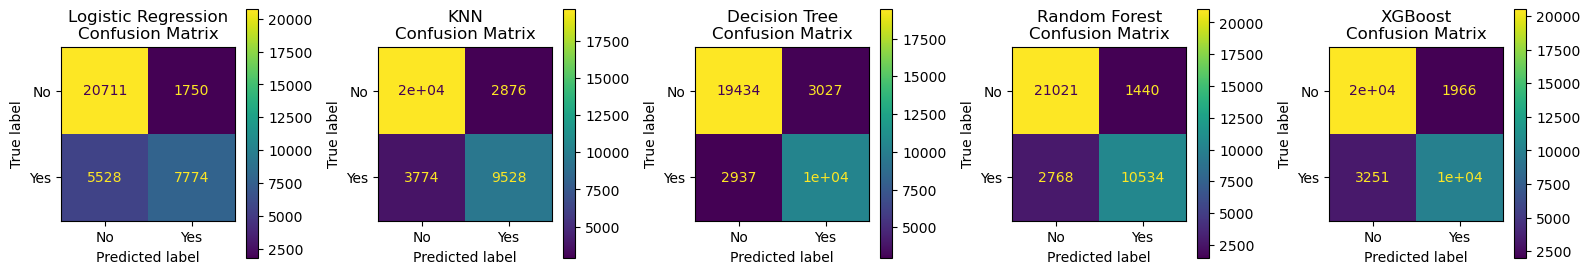

In [59]:
%%time
# Display all the saved plots
figsize=(16,3)
image_name = 'images/models_comparision_confusion_matrices.png'
plot_confusion_matrices_subplots(model_comp_plots, X_test, y_test, figsize, image_name)

### <font color='purple'>Observations:</font>
   - All models have a high number of true positives and true negatives. It indicates that the models are able to correctly classify the majority of instances. 
   - The Logistic Regression model has a lower number of true positives than the other models. It is less good at classifying positive instances.  

In [60]:
# Set max_colwidth so that best params values are not truncated
pd.set_option('display.max_colwidth', 1000)
print_best_params(model_comp_plots)

Model Name              Best Params
0  Logistic Regression               {'C': 1.0}
1                  KNN       {'n_neighbors': 5}
2        Decision Tree  {'min_samples_leaf': 1}
3        Random Forest  {'min_samples_leaf': 1}
4              XGBoost         {'max_depth': 2}

In [61]:
model_comp_results

Model  CV Score  Train Time  Train Accuracy  Test Accuracy  \
0  Logistic Regression  0.795235    0.478037        0.795235       0.796494   
1                  KNN  0.808417    0.029430        0.872758       0.814054   
2        Decision Tree  0.826728    0.964963        1.000000       0.833235   
3        Random Forest  0.876880   13.895972        0.999988       0.882336   
4              XGBoost  0.851798    0.574176        0.853200       0.854123   

   Precision    Recall  F1-Score   ROC AUC  Balanced Accuracy  Inference Time  
0   0.799339  0.796494  0.787546  0.753255           0.753255        0.002851  
1   0.812289  0.814054  0.812628  0.794120           0.794120        8.425000  
2   0.833474  0.833235  0.833349  0.822220           0.822220        0.004399  
3   0.882192  0.882336  0.880935  0.863900           0.863900        0.334821  
4   0.853164  0.854123  0.852450  0.834036           0.834036        0.012667

### <font color='purple'>Observations:</font>   
   - Random Forest is the best model based on CV score and test accuracy, indicating strong generalization.
   - Logistic Regression is the fastest model to train and test.
   - Decision Tree has the best precision and F1-Score.
   - Random Forest has the best recall and ROC AUC.
   - All models have high balanced accuracy.
   
   **NOTE: Random Forest model performs the best, with high accuracy, precision, recall, F1-Score, ROC AUC, and balanced accuracy scores.**

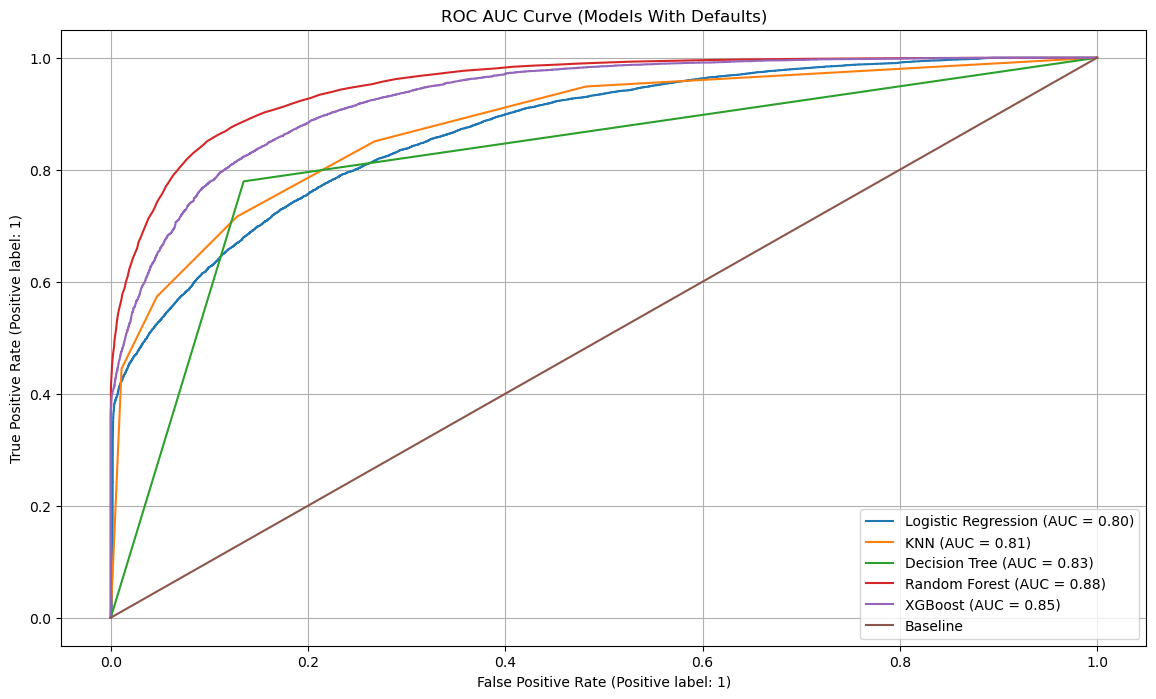

In [62]:
title = 'ROC AUC Curve (Models With Defaults)'
image_name = 'images/models_comparision_roc_auc_curve.png'
plot_roc_auc_curve(model_comp_plots)

## <span style="color:#d35400">Improve the Model:</span>

In [63]:
# Set the range of alpha values to tune
alphas = np.logspace(-3, 3, 100)

# Create a RidgeCV model with cross-validation
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

# Fit the model to your data
ridge_cv.fit(X_scaled, y)

# Get the optimal alpha value
best_alpha = ridge_cv.alpha_

print('Best alpha:', best_alpha)

Best alpha: 61.35907273413176


In [64]:
def feature_importance(X, y):
    # Calculate feature importance
    model = Ridge(alpha = best_alpha).fit(X, y)
    feature_importances = permutation_importance(model, X, y, n_jobs=3)

    # Create a DataFrame of feature importances
    feature_importances_df = pd.DataFrame({
        'feature': X.columns,
        'importance': feature_importances.importances_mean
    })

    # Sort the DataFrame by importance in descending order
    return feature_importances_df.sort_values(by='importance', ascending=False)

# Find the feature importance
feature_importance(X_scaled, y)

feature    importance
12                    deposit_type  2.215033e-01
6                   market_segment  8.029976e-02
5                          country  7.306149e-02
18       total_of_special_requests  5.130851e-02
26          reserved_room_assigned  3.492466e-02
1                        lead_time  3.107432e-02
17     required_car_parking_spaces  2.791689e-02
7             distribution_channel  9.672048e-03
11                 booking_changes  8.383711e-03
16                             adr  8.083180e-03
9           previous_cancellations  3.219706e-03
24                    total_guests  3.041961e-03
23                     total_stays  2.200067e-03
0                            hotel  2.190290e-03
15                   customer_type  1.382510e-03
2               arrival_date_month  1.182527e-03
14            days_in_waiting_list  7.769214e-04
20                           email  1.633545e-04
3         arrival_date_week_number  1.591139e-04
19                            name  1.463295e-04
10  previous_bookings_not_canceled  1.296676e-04
13                           agent  1.237145e-04
25                  total_children  7.863908e-05
21                    phone-number  2.608923e-05
4                             meal  2.453717e-05
22                     credit_card  6.286325e-06
8                is_repeated_guest  9.914900e-07

In [65]:
# Find variance inflation factor
def VIF(X):
    # Calculate the VIF for each feature
    vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

    # Create a DataFrame with the VIF values
    vif_df = pd.DataFrame({'Feature': X.columns, 'VIF': vif})

    # Sort the DataFrame by VIF
    return vif_df.sort_values(by='VIF', ascending=False)


VIF(X)

Feature        VIF
6                   market_segment  69.857558
7             distribution_channel  54.162207
15                   customer_type  21.559611
0                            hotel  16.428163
12                    deposit_type  16.133728
24                    total_guests  14.616159
19                            name   9.075115
20                           email   8.864706
26          reserved_room_assigned   8.618243
16                             adr   8.372270
5                          country   6.534851
3         arrival_date_week_number   5.631309
2               arrival_date_month   4.871887
21                    phone-number   3.931990
22                     credit_card   3.919200
23                     total_stays   3.447870
4                             meal   3.420273
1                        lead_time   2.759010
13                           agent   2.652815
18       total_of_special_requests   1.827640
25                  total_children   1.737061
8                is_repeated_guest   1.336645
10  previous_bookings_not_canceled   1.264720
11                 booking_changes   1.182147
17     required_car_parking_spaces   1.165186
14            days_in_waiting_list   1.069835
9           previous_cancellations   1.066166

### <font color='purple'>Observations:</font>
   - Based on VIF and feature importance we can drop the below columns:
   - name: This feature has a very low importance score of 0.000243 and a high VIF value of 9.075115. This means that the name of the customer is not very useful for predicting the cancellation and is highly dependent on other features such as email and phone number.
   - email: This feature has a low importance score of 0.000112 and a high VIF value of 8.864706. This means that the email of the customer is not very informative for the model and is highly correlated with other features such as name and phone number.
   - credit_card: This feature has a very low importance score of 0.000009 and a high VIF value of 3.919200. This means that the credit card information of the customer is not relevant for the prediction and is highly influenced by other features such as phone number and country.
   - is_repeated_guest: This feature has a very low importance score of 0.000004 and a low VIF value of 1.336645. This means that the feature is not very helpful for the model and does not have much variation in its values.

In [66]:
useless_col = ['name', 'email', 'credit_card', 'is_repeated_guest']
data.drop(useless_col, axis = 1, inplace = True)

# Reset the index after dropping the features.
data.reset_index(drop=True, inplace=True)

In [67]:
# Split data into features (X) and target variable (y)
X = data.drop(columns='is_canceled')
y = data['is_canceled']

# Feature scaling (e.g., standardization or normalization)
# Using MinMaxScaler to see any improvement in the models.

# Initialize the MinMaxScaler
minmax_scaler = MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)

## <span style="color:#d35400">Models with Hyperparameter Tuning:</span>

In [68]:
models = {    
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

params = {
    'Logistic Regression': {
        'C': [1.0, 10.0, 100.0],
        'solver': ['lbfgs', 'liblinear'],
        'penalty': ['l1','l2'],
        'max_iter': [1000, 2000, 3000], 
    },
    'KNN': {
        'n_neighbors': [10, 20, 30, 40],
        'p': [1,2],
        'metric': ['euclidean', 'manhattan'],
        'weights': ['uniform', 'distance'],
        'n_jobs':[5, 7, 9]
    },
    'Decision Tree': {
        'min_samples_leaf': [1, 2, 3],
        'criterion': ['gini'],
        'max_depth': [10, 20, 30],
        'max_features': ['sqrt', 'log2', 'auto'],
        'splitter': ['best', 'random'],
        'min_samples_split': [2, 3, 5]
    },
    'Random Forest': {
        'max_depth': [5, 10, 15, 20],
        'n_estimators': [100, 200, 300],
        'min_samples_leaf': [5, 10, 15],
        'min_samples_split': [2, 3, 5],
        'bootstrap': [True, False],
        'oob_score': [True, False],
        'max_features': ['sqrt', 'log2', 'auto']
    },
    'XGBoost': {
        'max_depth': [3, 5, 10, 20],
        'learning_rate': [0.1, 0.05, 0.13, 0.3],
        'n_estimators': [30, 50, 70, 90],
        'reg_alpha': [0, 0.1, 0.5, 1.0],
        'reg_lambda': [0, 0.1, 0.5, 1.0]
    }
}

In [69]:
%%time
# Evaluate each model
model_tuned_comp_results, model_tuned_comp_plots = evaluate_models(models, params, X_train, y_train, X_test, y_test, 
                                                       5, 'accuracy', 9)

CPU times: user 14min 11s, sys: 3min 55s, total: 18min 6s
Wall time: 1h 48min 15s


CPU times: user 51.3 s, sys: 7.21 s, total: 58.5 s
Wall time: 12.3 s


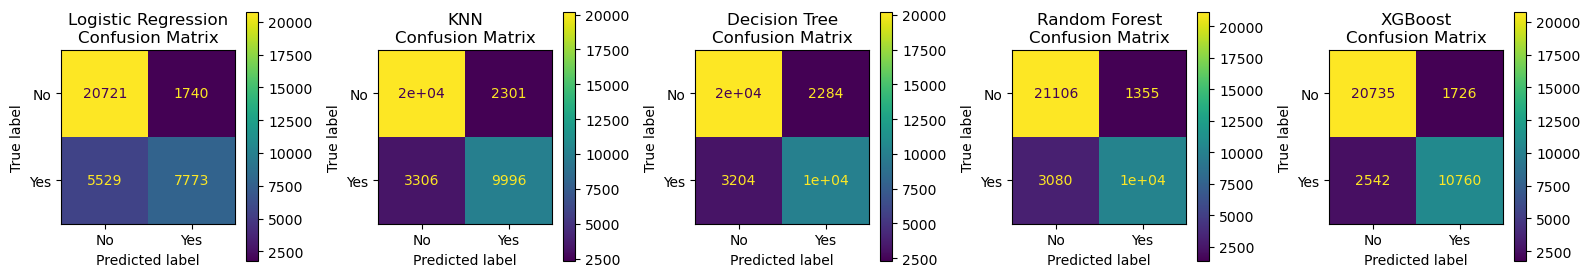

In [70]:
%%time
# Display all the saved plots
figsize=(16,3)
image_name = 'images/models_tuned_comparision_confusion_matrices.png'
plot_confusion_matrices_subplots(model_tuned_comp_plots, X_test, y_test, figsize, image_name)

### <font color='purple'>Observations:</font>
   - All models are good at predicting positive cases, negative cases, avoiding false positives and false negatives, but Logistic Regression and KNN are the best.
   - The data set has more negative cases than positive cases, which makes it harder to predict positive cases.
   - Decision Tree and Random Forest are more complex models, which makes them more likely to learn the noise in the training data and not generalize well.
   - XGBoost is a tree-based ensemble boosting model with the lowest FPR and FNR, which makes it more stable and less likely to overfit.

In [71]:
# Print best params from all the models    
print_best_params(model_tuned_comp_plots)

Model Name  \
0  Logistic Regression   
1                  KNN   
2        Decision Tree   
3        Random Forest   
4              XGBoost   

                                                                                                                                           Best Params  
0                                                                               {'C': 100.0, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}  
1                                                               {'metric': 'manhattan', 'n_jobs': 5, 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}  
2                    {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'best'}  
3  {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 300, 'oob_score': True}  
4                                                    {'learning_rate': 0.13, 'max_depth': 10, 'n_estimators': 90, 'reg_alpha': 0.5, 'reg_lambda': 1.0}

In [72]:
model_tuned_comp_results

Model  CV Score  Train Time  Train Accuracy  Test Accuracy  \
0  Logistic Regression  0.795283    9.004088        0.795391       0.796745   
1                  KNN  0.837262    0.022554        1.000000       0.843218   
2        Decision Tree  0.829341    0.147129        0.899757       0.846545   
3        Random Forest  0.875310   36.513863        0.897096       0.875989   
4              XGBoost  0.866167    1.241655        0.907918       0.880659   

   Precision    Recall  F1-Score   ROC AUC  Balanced Accuracy  Inference Time  
0   0.799682  0.796745  0.787773  0.753440           0.753440        0.002395  
1   0.841919  0.843218  0.841856  0.824511           0.824511        0.813393  
2   0.845325  0.846545  0.845337  0.828723           0.828723        0.001492  
3   0.876486  0.875989  0.873983  0.854065           0.854065        0.019085  
4   0.879996  0.880659  0.879835  0.866028           0.866028        0.004983

### <font color='purple'>Observations:</font>   
   - XGBoost is the best model based on test accuracy, precision, recall, f1-score and roc-auc.
   - Logistic Regression is the worst performing model, which has fastest inference time.
   - Decision Tree has the faster training and inference times.
   - KNN has faster training time and high CV score.
   - Random Forest has the best CV score.
   - All models have high balanced accuracy.
   
   **NOTE: XGBoost model performs the best, with high accuracy, precision, recall, F1-Score, ROC AUC, and balanced accuracy scores.**

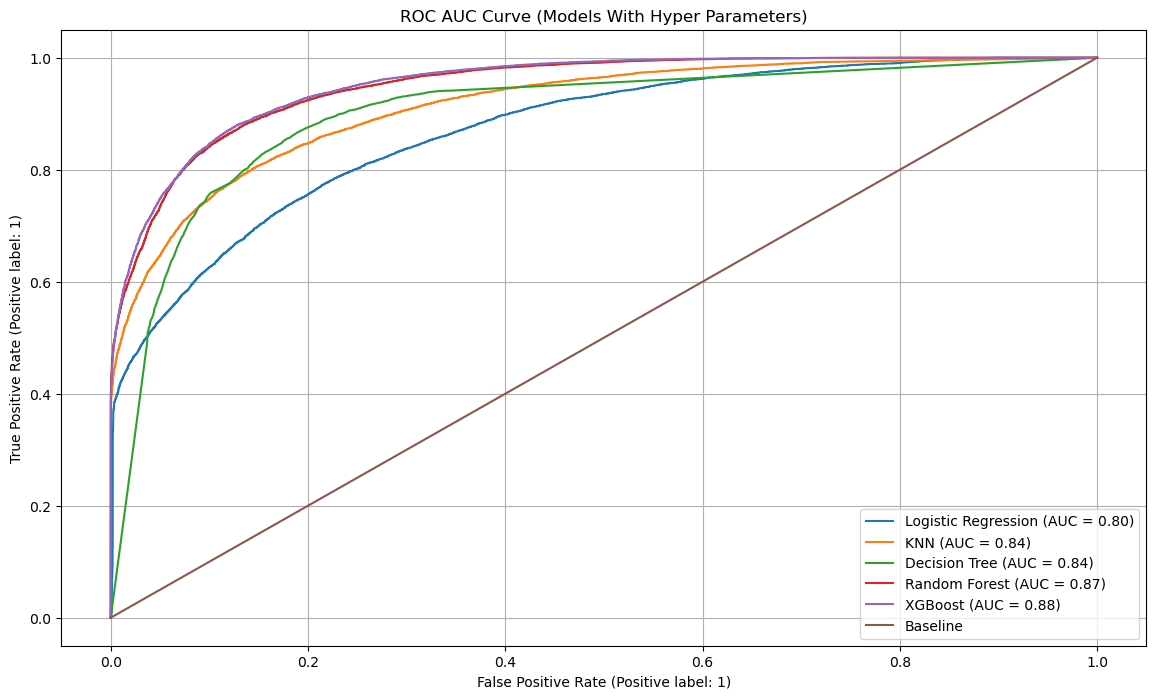

In [73]:
title = 'ROC AUC Curve (Models With Hyper Parameters)'
image_name = 'images/models_tuned_comparision_roc_auc_curve.png'
plot_roc_auc_curve(model_tuned_comp_plots)

## <span style="color:#d35400">Models with SMOTE and Hyperparameter Tuning:</span>

In [74]:
# Balance the minority class using SMOTE
sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)

print('Resampled dataset shape %s' % Counter(y_res))

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the scaled features
X_scaled = pd.DataFrame(scaler.fit_transform(X_res), columns=X_res.columns, index=X_res.index)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=test_size, random_state=random_state)

Resampled dataset shape Counter({0: 75011, 1: 75011})


In [75]:
%%time
# Evaluate each model
model_smote_comp_results, model_smote_comp_plots = evaluate_models(models, params, X_train, y_train, 
                                                                   X_test, y_test, 5, 'accuracy', 9)

CPU times: user 18min 17s, sys: 7min 50s, total: 26min 7s
Wall time: 2h 20min 32s


CPU times: user 1min 17s, sys: 15.2 s, total: 1min 32s
Wall time: 17.8 s


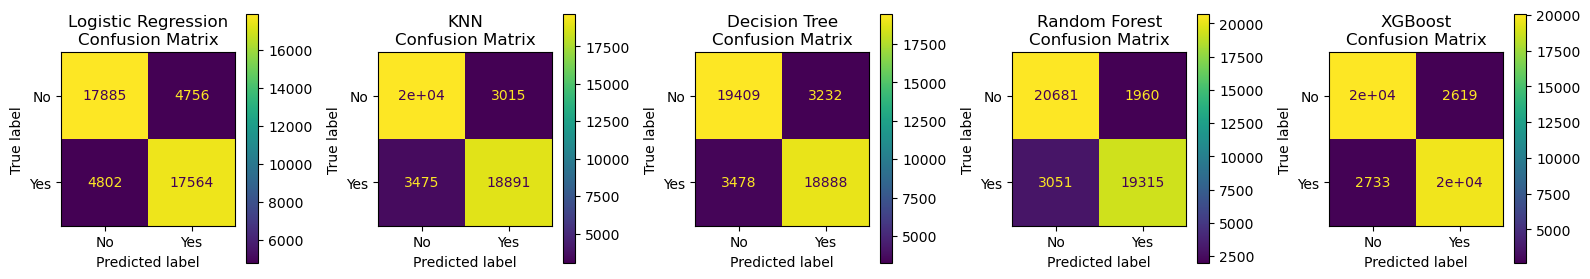

In [76]:
%%time
# Display all the saved plots
figsize=(16,3)
image_name = 'images/models_smote_comparision_confusion_matrices.png'
plot_confusion_matrices_subplots(model_smote_comp_plots, X_test, y_test, figsize, image_name)

### <font color='purple'>Observations:</font>
   - The XGBoost model is the best one. It is making the fewest errors of all the models. 
   - The Logistic Regression model is the worst one. It is making more false negatives than false positives. 
   - The KNN, Decision Tree, and Random Forest models are all making more false positives than false negatives. These more likely to incorrectly predict a positive case as negative than vice versa.

In [77]:
# Print best params from all the models    
print_best_params(model_smote_comp_plots)

Model Name  \
0  Logistic Regression   
1                  KNN   
2        Decision Tree   
3        Random Forest   
4              XGBoost   

                                                                                                                                            Best Params  
0                                                                                {'C': 100.0, 'max_iter': 3000, 'penalty': 'l1', 'solver': 'liblinear'}  
1                                                                {'metric': 'manhattan', 'n_jobs': 9, 'n_neighbors': 20, 'p': 2, 'weights': 'distance'}  
2                     {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}  
3  {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200, 'oob_score': False}  
4                                                       {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 1.0, 'reg_lambda': 1.0}

In [78]:
model_smote_comp_results

Model  CV Score  Train Time  Train Accuracy  Test Accuracy  \
0  Logistic Regression  0.782431   10.517663        0.782822       0.787633   
1                  KNN  0.847803    0.024607        1.000000       0.855800   
2        Decision Tree  0.842622    0.172931        0.896024       0.850912   
3        Random Forest  0.886159   33.509349        0.910537       0.888662   
4              XGBoost  0.892434    0.511624        0.881636       0.881085   

   Precision    Recall  F1-Score   ROC AUC  Balanced Accuracy  Inference Time  
0   0.787632  0.787633  0.787631  0.787619           0.787619        0.002181  
1   0.855931  0.855800  0.855776  0.855732           0.855732        1.303832  
2   0.850944  0.850912  0.850903  0.850873           0.850873        0.001480  
3   0.889545  0.888662  0.888580  0.888509           0.888509        0.018098  
4   0.881091  0.881085  0.881083  0.881065           0.881065        0.004955

### <font color='purple'>Observations:</font>
   - The KNN model shows perfect training accuracy (100%), indicating potential overfitting.
   - Decision Tree has lowest inference time.
   - Random Forest has high train accuracy and F1-score.
   - XGBoost appears to be the best model for this task, as it has the highest CV score and test accuracy.  
   
   **NOTE: XGBoost and Random Forest models are the best performing models among the models, but they are also the most computationally expensive models.**

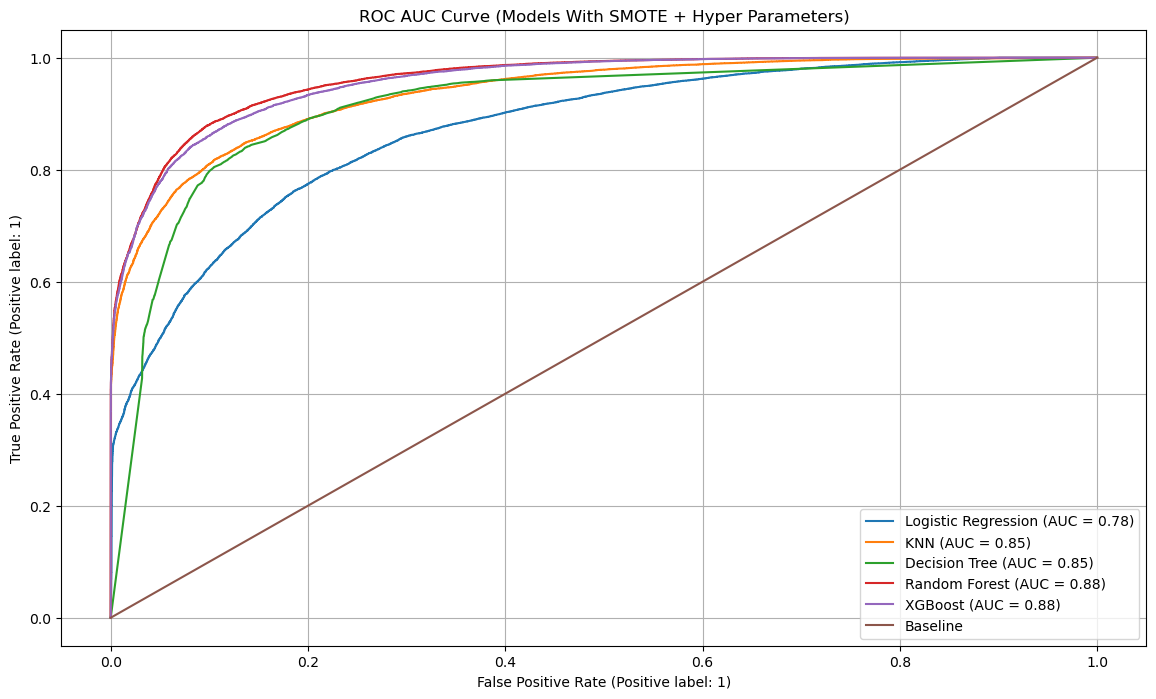

In [79]:
title = 'ROC AUC Curve (Models With SMOTE + Hyper Parameters)'
image_name = 'images/models_smote_tuned_comparision_roc_auc_curve.png'
plot_roc_auc_curve(model_smote_comp_plots)

## <span style="color:#d35400">Conclusion:</span>

   - Based on the above model evaluation results, I recommend using Random Forest to predict hotel booking cancellations.
   - Random Forest consistently outperformed other models in terms of various evaluation metrics, even after hyperparameter tuning and the inclusion of SMOTE.
   - Random Forest is particularly strong in handling the class imbalance associated with predicting hotel booking cancellations.

## <span style="color:#d35400">Next Steps:</span>

   - Fine-tune the hyperparameters of the Random Forest model to further improve its performance.
   - Conduct a feature importance analysis for the Random Forest model to understand which features contribute the most to the predictions.
   - Try other machine learning models, such as Neural Networks.